# Feature Selection

Authors: Brian R. Mullen, Sero Toriano Parel, Revati Jadhav, Carrie Clark, Philip Nelson

Date: 2025-10-21

Python notebook re: feature elimination decisions, logs results in a table

Main output(s):
- feature_selection.csv: feature importance log, a tabular record of the ranking of all features by importance score (as per [02_EDA_feature_selection_and_engineering](https://docs.google.com/document/d/1Kl0Oz5YV63c0b6lbUHhTlcTJ7h4KpRAAGrQZfKX6Zyw/edit?usp=sharing))
- train_calib_selected.csv: per-user training/calibration rows with only the selected features
- test_holdout_selectedcsv: per-user test holdout rows with only the selected features

Other output(s):
- (OLD) feature_importance_ranking: global RF importance table (created/loaded in the “Pooled” section)
- (OLD) tsne_feature_results_global.npy: cached t-SNE (global)
- tsne_feature_results_per_user.npy: cached t-SNE (per-user)

Subgoals: Build personalized models for each user using their optimal feature subset

## Imports

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

# Load the cleaned data from EDA
cleaned_data_path = "../data/processed/features_emg_data_cleaned.csv"
df_no_outliers = pd.read_csv(cleaned_data_path)
print(f"Loaded cleaned data: {df_no_outliers.shape}")

# Define feature columns (same logic as before)
metadata_cols = ['user', 'gesture', 'stage', 'is_outlier']
all_columns = df_no_outliers.columns.tolist()
feature_cols = [col for col in all_columns if col not in metadata_cols]
print(f"Feature columns: {len(feature_cols)}")

Loaded cleaned data: (135299, 164)
Feature columns: 160


In [2]:
# Preview
df_no_outliers.head(5)

ch00_rms   ch01_rms   ch02_rms   ch03_rms   ch04_rms   ch05_rms  \
0   9.989673  12.824719  19.425159  32.592478  29.791715  19.048967   
1  23.066061  23.888872  35.386110  39.688074  28.867694  20.743550   
2  15.647086  25.068543  43.062281  54.325056  34.475540  22.649844   
3   9.577057  12.880236  19.681067  25.718243  18.829439  16.082287   
4  28.080062  41.913348  71.097516  85.425059  55.060205  37.417092   

    ch06_rms   ch07_rms   ch08_rms   ch09_rms  ...  ch10_thresh2-events  \
0  12.083390   9.291876   9.474774  12.034365  ...                  2.0   
1  13.941204  11.463285  12.957853  17.214658  ...                  4.0   
2  15.232970  12.238017  11.391191  10.820393  ...                  0.0   
3  11.626173   9.934410   9.711847  10.385964  ...                  1.0   
4  27.184023  23.667525  23.080325  24.790593  ...                  6.0   

   ch11_thresh2-events  ch12_thresh2-events  ch13_thresh2-events  \
0                  1.0                  6.0                  4.0   
1                  5.0                  6.0                  7.0   
2                  2.0                  4.0                  6.0   
3                  3.0                  3.0                  3.0   
4                  6.0                  9.0                  8.0   

   ch14_thresh2-events  ch15_thresh2-events      gesture  \
0                  5.0                  4.0  index_press   
1                 10.0                  4.0  index_press   
2                  5.0                  8.0  index_press   
3                  2.0                  3.0  index_press   
4                  9.0                  9.0  index_press   

                                        stage  user  is_outlier  
0  pinch_release_static_hand_in_lap_with_taps    19       False  
1  pinch_release_static_hand_in_lap_with_taps    19       False  
2  pinch_release_static_hand_in_lap_with_taps    19       False  
3  pinch_release_static_hand_in_lap_with_taps    19       False  
4  pinch_release_static_hand_in_lap_with_taps    19        True  

[5 rows x 164 columns]

## Configs

In [3]:
# FEATURE SELECTION CONFIGURATION - EDIT THESE VALUES TO ITERATE

# Starting pool: how many top features to consider before redundancy removal
STARTING_POOL_SIZE = 80

# Correlation threshold: features with correlation above this will be considered redundant
CORRELATION_THRESHOLD = 0.90

print(f"STARTING_POOL_SIZE = {STARTING_POOL_SIZE}")
print(f"CORRELATION_THRESHOLD > {CORRELATION_THRESHOLD}")

STARTING_POOL_SIZE = 80
CORRELATION_THRESHOLD > 0.9


## Data split

In [4]:
# Personalization split: 80% train/calibration, 20% test PER USER, stratified by stage and gesture
# CRITICAL: Split data BEFORE feature selection to prevent data leakage
# Ensures test data doesn't influence which features we select

# add a column containing both stage and gesture
df_no_outliers['stage_gesture'] = df_no_outliers['stage']+'__'+df_no_outliers['gesture']

# identify user-stage-gesture combinations with limited data points.
# create a new column containing this information, with default value 'many', which will be updated in the next step
df_no_outliers['how_many_stage_gesture'] = 'many'

# check for user-stage-gesture combinations with fewer than 5 data points, and update 'how_many_stage_gesture' column
for user_id in df_no_outliers['user'].unique():
    user_data = df_no_outliers[df_no_outliers['user'] == user_id]
    for stage_gesture_name in user_data['stage_gesture'].unique():
        if 1 < user_data['stage_gesture'].value_counts()[stage_gesture_name] < 5:
            df_no_outliers.loc[(df_no_outliers['stage_gesture'] == stage_gesture_name) & (df_no_outliers['user'] == user_id),'how_many_stage_gesture'] = 'few'
        if user_data['stage_gesture'].value_counts()[stage_gesture_name] == 1:
            df_no_outliers.loc[(df_no_outliers['stage_gesture'] == stage_gesture_name) & (df_no_outliers['user'] == user_id),'how_many_stage_gesture'] = 'one'

# separate the data into three frames 
df_one_stage_gesture = df_no_outliers[df_no_outliers['how_many_stage_gesture'] == 'one']
df_few_stage_gesture = df_no_outliers[df_no_outliers['how_many_stage_gesture'] == 'few']
df_many_stage_gesture = df_no_outliers[df_no_outliers['how_many_stage_gesture'] == 'many']

# now we are ready to split the data
train_pieces, test_pieces = [], []

# split df_few_stage_gesture by keeping 1 data point for testing from each user-stage-gesture combination 
for user_id in df_few_stage_gesture['user'].unique():
    user_data = df_few_stage_gesture[df_few_stage_gesture['user'] == user_id]
    
    for stage_gesture in user_data.stage_gesture.unique():
        user_train = user_data[user_data['stage_gesture'] == stage_gesture].iloc[1:,:]
        user_test = user_data[user_data['stage_gesture'] == stage_gesture].iloc[[0]]
    
        train_pieces.append(user_train)
        test_pieces.append(user_test)

# split df_many_stage_gesture for each user, stratifying by stage and gesture 
for user_id in df_many_stage_gesture['user'].unique():
    user_data = df_many_stage_gesture[df_many_stage_gesture['user'] == user_id]
    
    # Split: 80% train, 20% test
    user_train, user_test = train_test_split(
        user_data, test_size=0.2, random_state=13, shuffle=True, stratify=user_data.stage_gesture
    )
    
    train_pieces.append(user_train)
    test_pieces.append(user_test)

# Combine all pieces
df_train = pd.concat(train_pieces+[df_one_stage_gesture])
df_test = pd.concat(test_pieces)

# remove 'stage_gesture' and 'how_many_stage_gesture' columns
df_no_outliers = df_no_outliers.drop(columns=['stage_gesture','how_many_stage_gesture'])
df_train = df_train.drop(columns=['stage_gesture','how_many_stage_gesture'])
df_test = df_test.drop(columns=['stage_gesture','how_many_stage_gesture'])

print(f"Original: {df_no_outliers.shape}")
print(f"Train: {df_train.shape}")
print(f"Test: {df_test.shape}")

Original: (135299, 164)
Train: (108187, 164)
Test: (27112, 164)


In [5]:
# DOUBLE CHECK

# Quick verification
print(f"# of users in both sets: {df_train['user'].nunique()}")

# Show sample user splits (first 3)
sample_data = []
for user_id in [0, 1, 2]:
    orig = len(df_no_outliers[df_no_outliers['user'] == user_id])
    calib = len(df_train[df_train['user'] == user_id])
    test = len(df_test[df_test['user'] == user_id])
    
    sample_data.append({
        'User': user_id,
        'Original': orig,
        'Calibration': f"{calib} ({calib/orig*100:.1f}%)",
        'Test': f"{test} ({test/orig*100:.1f}%)"
    })

display(pd.DataFrame(sample_data))

# of users in both sets: 100


User  Original   Calibration         Test
0     0      1767  1413 (80.0%)  354 (20.0%)
1     1      1085   868 (80.0%)  217 (20.0%)
2     2      1755  1404 (80.0%)  351 (20.0%)

### Save full feature set

In [6]:
# SAVE FULL FEATURE SET FOR REGULARIZED MODELS
# to ensure modeling_experiments.ipynb can access all 160 features

# Create copies of train/test with ALL features (before selection)
train_full_features = df_train[['user', 'gesture', 'stage'] + feature_cols].copy()
test_full_features = df_test[['user', 'gesture', 'stage'] + feature_cols].copy()

# Save to processed data folder
train_full_features.to_csv("../data/processed/train_calib_full.csv", index=False)
test_full_features.to_csv("../data/processed/test_holdout_full.csv", index=False)

## Feature transformation

- Feature transformation to address skewness in EMG data
- Our EMG data is positive-only and right-skewed
- Log transformation can help make distributions look more normal

In [7]:
# PIPELINE for LOG TRANSFORMATION

# Create preprocessing pipeline
# preprocessing_pipeline = Pipeline([('log_transform', FunctionTransformer(np.log1p))])
preprocessing_pipeline = Pipeline([('log_transform', FunctionTransformer(np.log1p)),('scaler', StandardScaler())])

# Fit on training data and transform both datasets
X_train_processed = preprocessing_pipeline.fit_transform(df_train[feature_cols])
X_test_processed = preprocessing_pipeline.transform(df_test[feature_cols])

# Convert back to DataFrames to keep column names
X_train_processed = pd.DataFrame(X_train_processed, columns=feature_cols, index=df_train.index)
X_test_processed = pd.DataFrame(X_test_processed, columns=feature_cols, index=df_test.index)

print(f"Training data shape: {X_train_processed.shape}")
print(f"Test data shape: {X_test_processed.shape}")

# Show transformation results
stats_data = []
for feature in feature_cols[:5]:  # Just show first 5 features
    stats_data.append({
        'Feature': feature,
        'Orig_Mean': df_train[feature].mean(),
        'Orig_Std': df_train[feature].std(),
        'Log_Mean': X_train_processed[feature].mean(),
        'Log_Std': X_train_processed[feature].std()
    })

stats_df = pd.DataFrame(stats_data)
stats_df

Training data shape: (108187, 160)
Test data shape: (27112, 160)


Feature  Orig_Mean   Orig_Std      Log_Mean   Log_Std
0  ch00_rms  10.023737   9.596705  1.261004e-17  1.000005
1  ch01_rms   9.906073   9.363822  5.506383e-16  1.000005
2  ch02_rms   9.924751   9.362737 -1.197953e-16  1.000005
3  ch03_rms  11.014258  14.150577 -3.783011e-17  1.000005
4  ch04_rms  12.807514  16.715760  2.522007e-17  1.000005

## Pooled

### ⏳ Random forest for feature importance

Recall: 10 feature types per channel:
   1. fft-halfwidth
   2. fft-highfreq
   3. fft-lowfreq
   4. fft-maxpower
   5. fft-peakfreq
   6. mav
   7. maxabs
   8. rms
   9. thresh2-events
  10. thresh3-events

In [8]:
# NOTE: May take some time to run! ⏳

# Check if already ran this before
# If already saved the results, just load them to save time
# File where to save feature importance results:
importance_file = "../data/processed/feature_importance_ranking.csv"

# To recalculate everything, UNCOMMENT the next line:
# if os.path.exists(importance_file): os.remove(importance_file)

# Check if already have the results saved
if os.path.exists(importance_file):
    # If file exists, just load it instead of recalculating    
    # Read CSV file with our previous results
    feature_importance_df = pd.read_csv(importance_file)
        
else:
    # If file doesn't exist, need to calculate everything
    
    # Get data ready for random forest
    # X has all our features
    # USE PROCESSED TRAINING DATA from our pipeline
    X = X_train_processed.copy()
    
    # y has what we're trying to predict (the gestures)
    # y = df_no_outliers['gesture']
    y = df_train['gesture']  

    print(f"We have {X.shape[0]} rows and {X.shape[1]} features in X")
    print(f"We have {len(y)} gesture labels in y")
    
    # Create random forest model using transformed and scaled features
    rf_model = RandomForestClassifier(
        n_estimators=100,    # How many trees in our forest
        random_state=13,    # Makes sure we get the same results every time
        # max_depth=20,       # How deep each tree can grow  
        n_jobs=-1           # Use all computer processors to speed things up
    )
    
    # Train model USING TRANSFORMED AND SCALED TRAINING DATA
    rf_model.fit(X, y)  # X now contains log-transformed and RobustScaled features
    
    # which features most important?
    importance_scores = rf_model.feature_importances_
    
    # Put results in table
    feature_importance_df = pd.DataFrame({
        'feature': feature_cols,        # names of all our features
        'importance': importance_scores  # How important each feature is
    })
    
    # Sort table so most important features are at the top
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
    
    # Save work so we don't have to do this again!
    feature_importance_df.to_csv(importance_file, index=False)
    
    # Clean up to save computer memory
    del X, y, rf_model

# Show top 20 most important features
print(feature_importance_df.head(20))

                feature  importance
0              ch05_rms    0.014057
1           ch05_maxabs    0.013697
2              ch04_rms    0.013419
3              ch05_mav    0.013037
4     ch04_fft-maxpower    0.012755
5           ch04_maxabs    0.012731
6     ch05_fft-maxpower    0.012129
7              ch04_mav    0.011810
8              ch03_rms    0.010958
9              ch06_mav    0.010749
10    ch11_fft-maxpower    0.010716
11  ch04_thresh2-events    0.010694
12             ch10_rms    0.010522
13          ch03_maxabs    0.010507
14             ch11_mav    0.010373
15             ch03_mav    0.010158
16    ch10_fft-maxpower    0.010151
17             ch06_rms    0.010079
18             ch07_mav    0.010042
19          ch13_maxabs    0.009967


In [9]:
# Print basic numbers re: importance scores
print(f"Most important feature score: {feature_importance_df['importance'].max():.6f}")
print(f"Least important feature score: {feature_importance_df['importance'].min():.6f}")
print(f"Average importance score: {feature_importance_df['importance'].mean():.6f}")

# Higher numbers suggest the feature is more important for predicting gestures
# Lower numbers suggest the feature doesn't help much with prediction
# Scores should add up to 1

Most important feature score: 0.014057
Least important feature score: 0.002573
Average importance score: 0.006250


### Top features

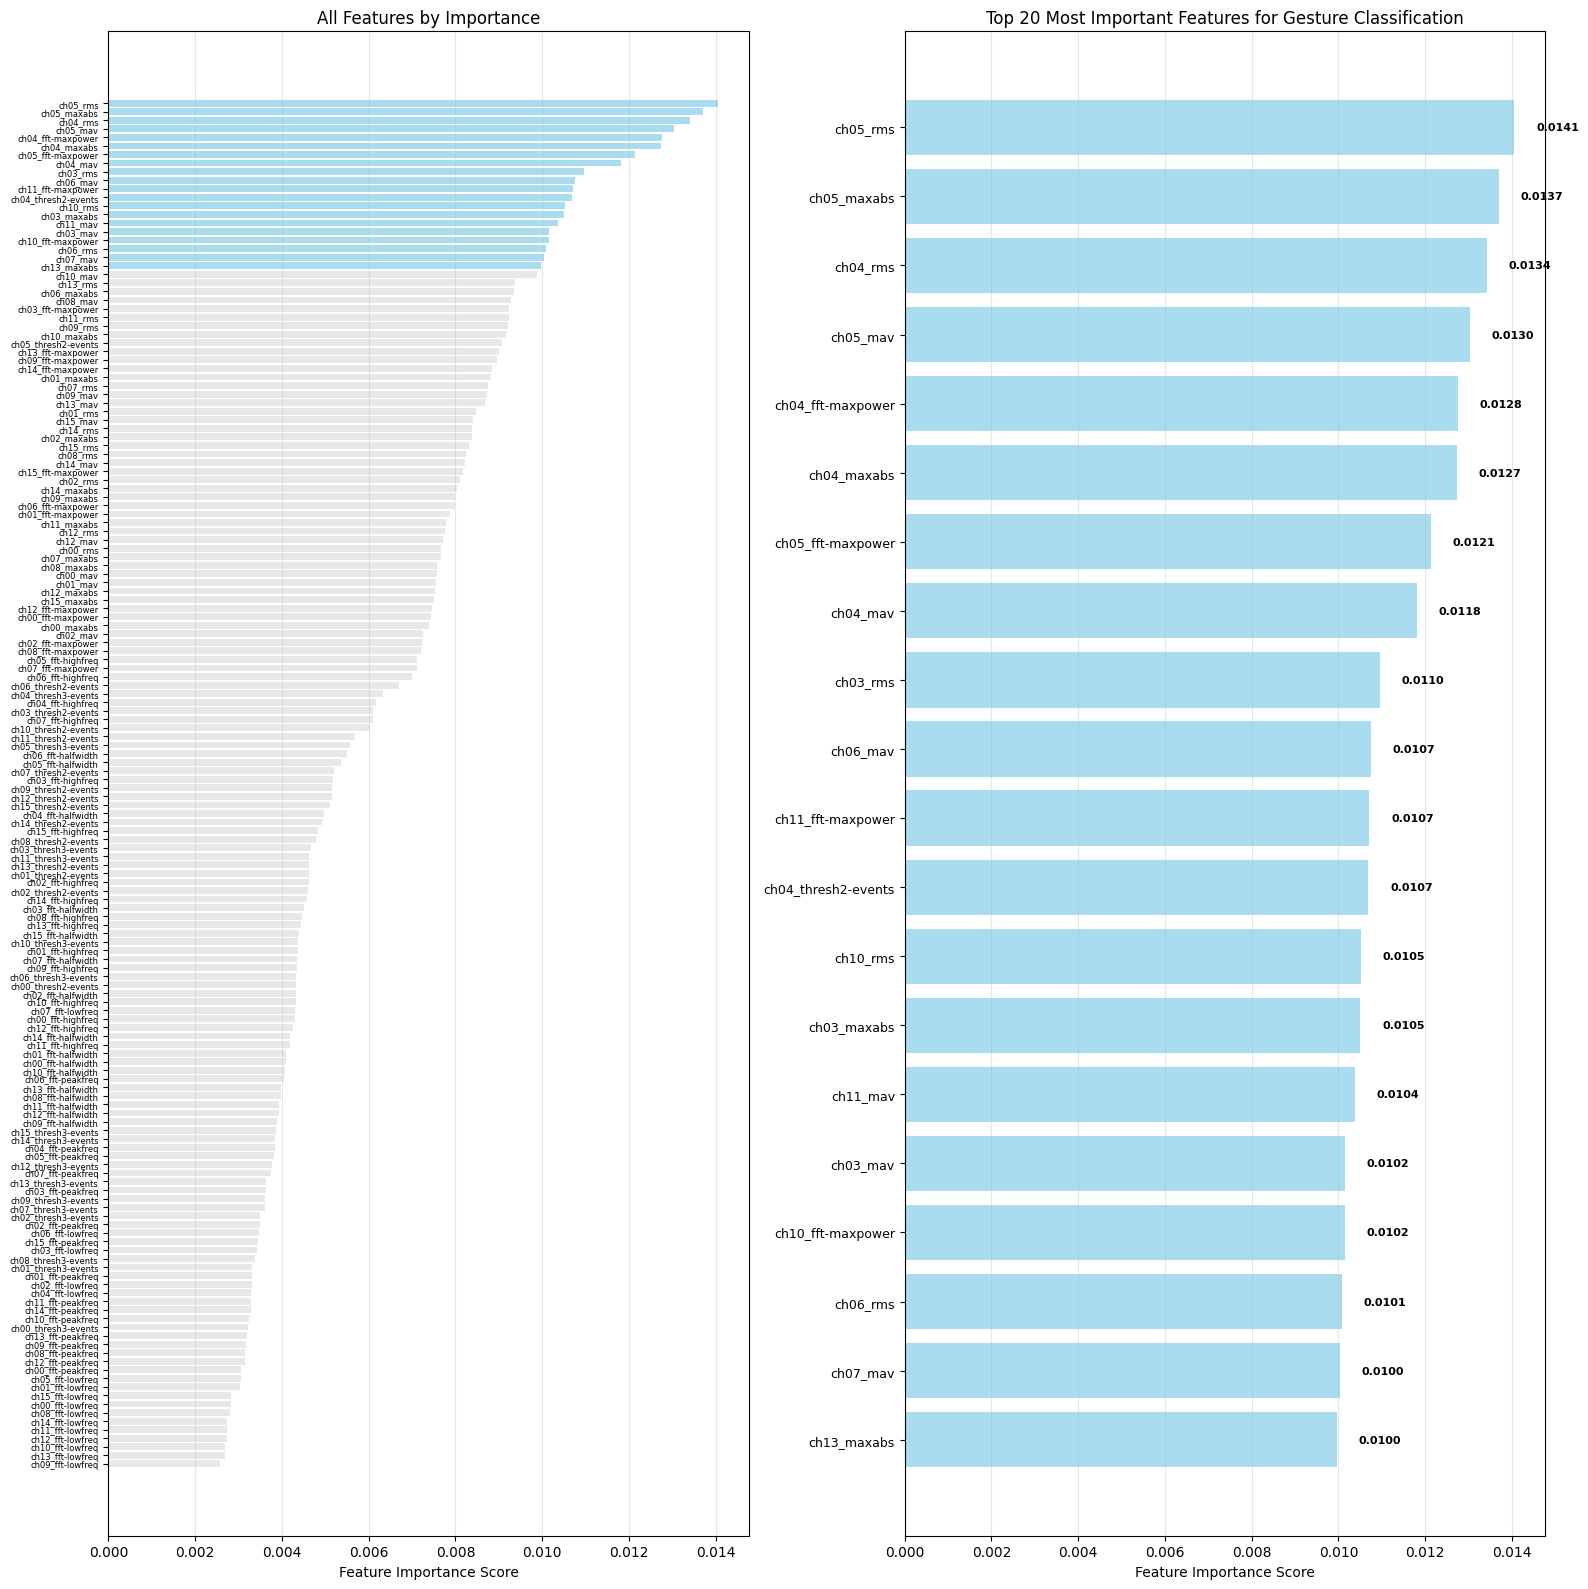

In [10]:
# Plot ALL features vs Top 20 features
all_features = feature_importance_df
top_20 = all_features.head(20)
remaining_features = all_features.iloc[20:]

plt.figure(figsize=(16, 16))

# Left: ALL features
plt.subplot(1, 2, 1)

# Plot top 20 features with one color
plt.barh(range(20), top_20['importance'], color='skyblue', alpha=0.7)

# Plot remaining features with different color
if len(remaining_features) > 0:
    plt.barh(range(20, len(all_features)), remaining_features['importance'], 
             color='lightgray', alpha=0.5)

plt.yticks(range(len(all_features)), all_features['feature'], fontsize=6)
plt.xlabel('Feature Importance Score')
plt.title('All Features by Importance', fontsize=12)
plt.gca().invert_yaxis()  # Most important at top
plt.grid(True, alpha=0.3, axis='x')
# REMOVED: plt.legend()

# Right: TOP 20 features only
plt.subplot(1, 2, 2)

bars = plt.barh(range(len(top_20)), top_20['importance'], color='skyblue', alpha=0.7)
plt.yticks(range(len(top_20)), top_20['feature'], fontsize=9)
plt.xlabel('Feature Importance Score')
plt.title('Top 20 Most Important Features for Gesture Classification', fontsize=12)
plt.gca().invert_yaxis()  # Most important at top
plt.grid(True, alpha=0.3, axis='x')

# Add importance scores to each bar in right plot
for i, (bar, importance) in enumerate(zip(bars, top_20['importance'])):
    plt.text(importance + 0.0005, i, f'{importance:.4f}', 
             va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

### Channel importance

> It seems as though we have a few more important channels than others.  We may want to highlight which contacts/electrodes have information and highlight that as a conclusion of our analysis (possibly for a redesign) —BM

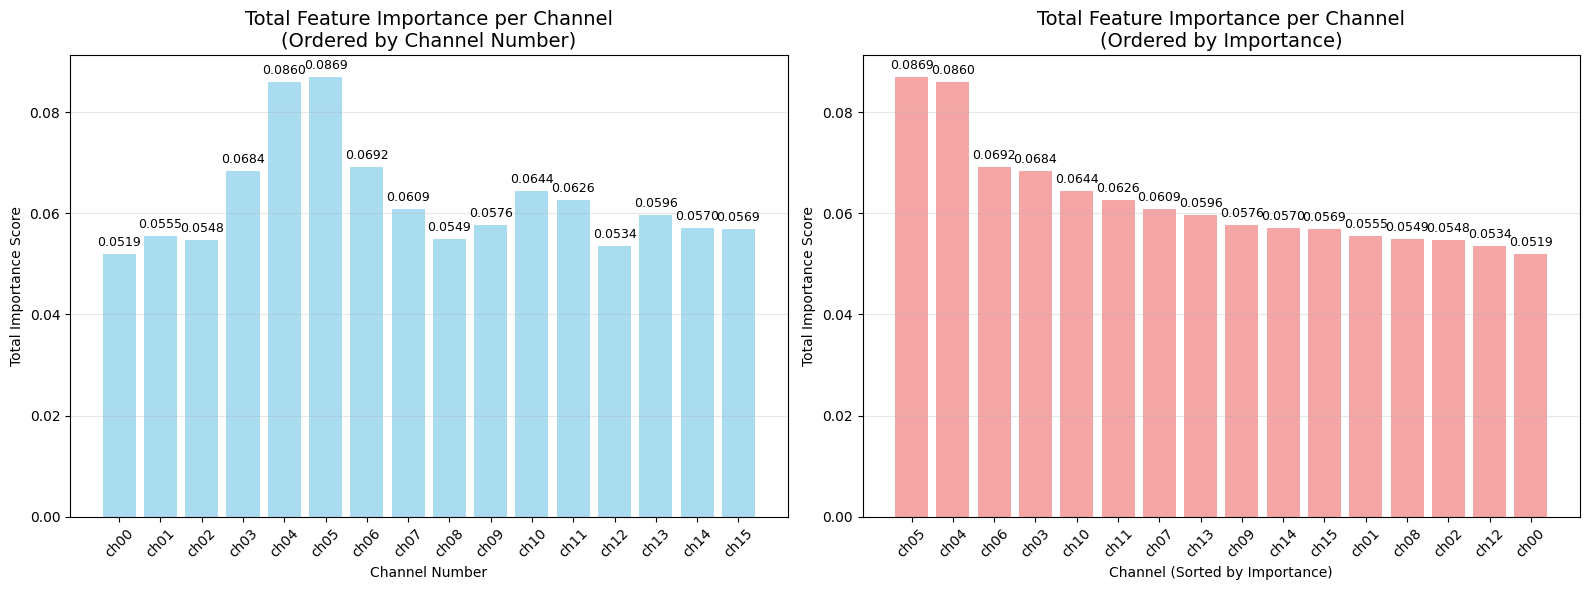

In [11]:
# Calculate total importance for each channel
# Tells us which physical electrodes give us the most useful signal

# Dictionary to store channel importance
channel_importance = {}

# Go through every feature and add up importance by channel
for i, row in feature_importance_df.iterrows():
    feature_name = row['feature']
    importance_score = row['importance']
    
    # Extract channel number from feature name
    if 'ch' in feature_name:
        # Find the channel number part
        start_index = feature_name.find('ch') + 2
        channel_num = ''
        
        # Read numbers after 'ch'
        for char in feature_name[start_index:]:
            if char.isdigit():
                channel_num += char
            else:
                break
        
        if channel_num:
            channel_name = f"ch{channel_num}"
            
            # Add this feature's importance to channel total
            if channel_name in channel_importance:
                channel_importance[channel_name] += importance_score
            else:
                channel_importance[channel_name] = importance_score

# Get all channel names and sort them two ways:
# 1. By channel number
# 2. By importance (highest to lowest)

# make sure we have all channels from ch00 to ch15
all_channels = [f"ch{str(i).zfill(2)}" for i in range(16)] 

# Sort by channel number
channels_by_number = sorted(channel_importance.keys())
importance_by_number = [channel_importance[ch] for ch in channels_by_number]

# Sort by importance (highest to lowest)
channels_by_importance = sorted(channel_importance.keys(), key=lambda x: channel_importance[x], reverse=True)
importance_by_importance = [channel_importance[ch] for ch in channels_by_importance]

# Create two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# LEFT PLOT: Ordered by channel number
bars1 = ax1.bar(channels_by_number, importance_by_number, color='skyblue', alpha=0.7)
ax1.set_title('Total Feature Importance per Channel\n(Ordered by Channel Number)', fontsize=14)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Total Importance Score')
ax1.tick_params(axis='x', rotation=45)

# Add numbers on top of bars
for bar, imp in zip(bars1, importance_by_number):
    if imp > 0:  # Only label bars with non-zero importance
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{imp:.4f}', ha='center', va='bottom', fontsize=9)

# Add grid for easier reading
ax1.grid(True, alpha=0.3, axis='y')

# RIGHT PLOT: Ordered by importance (highest to lowest)
bars2 = ax2.bar(channels_by_importance, importance_by_importance, color='lightcoral', alpha=0.7)
ax2.set_title('Total Feature Importance per Channel\n(Ordered by Importance)', fontsize=14)
ax2.set_xlabel('Channel (Sorted by Importance)')
ax2.set_ylabel('Total Importance Score')
ax2.tick_params(axis='x', rotation=45)

# Add numbers on top of bars
for bar, imp in zip(bars2, importance_by_importance):
    if imp > 0:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{imp:.4f}', ha='center', va='bottom', fontsize=9)

ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [12]:
# Some insights for redesign
# Calculate what percentage of total importance comes from top channels
total_all_importance = sum(importance_by_importance)
top_5_total = sum([channel_importance[ch] for ch in channels_by_importance[:5]])
print(f"Top 5 channels account for {top_5_total:.4f} ({top_5_total/total_all_importance:.1%}) of total importance:")
print(f"- Highest priority: Channels {', '.join(channels_by_importance[:5])} may be the most important for gesture recognition")
print(f"\nChannels {', '.join(channels_by_importance[-3:])} contribute the least")

Top 5 channels account for 0.3749 (37.5%) of total importance:
- Highest priority: Channels ch05, ch04, ch06, ch03, ch10 may be the most important for gesture recognition

Channels ch02, ch12, ch00 contribute the least


### ⏳ PCA & t-SNE

> we may want to develop some plots exploring dimension reduction and how our important features (and individuals) map to that space. PCA, t-SNE are both easy to implement using SciKit learn —BM

In [13]:
# Calculate feature correlation matrix
feature_correlation_matrix = df_no_outliers[feature_cols].corr()

# Color scheme for feature types
feature_color_map = {
    'fft-halfwidth': 'darkviolet',
    'fft-highfreq': 'mediumblue', 
    'fft-lowfreq': 'slateblue',
    'fft-maxpower': 'royalblue',
    'fft-peakfreq': 'deepskyblue',
    'mav': 'gold',
    'maxabs': 'orange',
    'rms': 'red',
    'thresh2-events': 'limegreen',
    'thresh3-events': 'forestgreen'
}

# Prepare feature colors
feature_colors = [feature_color_map[feature.split('_', 1)[1]] for feature in feature_cols]

# Run PCA
pca_features = PCA(n_components=2)
feature_pca_results = pca_features.fit_transform(feature_correlation_matrix)

# Run t-SNE (load if available/cached, otherwise (re-)compute)
tsne_results_file = "../data/processed/tsne_feature_results_global.npy"
if os.path.exists(tsne_results_file):
    feature_tsne_results = np.load(tsne_results_file)
else:    
    tsne_features = TSNE(n_components=2, random_state=13, perplexity=30)
    feature_tsne_results = tsne_features.fit_transform(feature_correlation_matrix)
    np.save(tsne_results_file, feature_tsne_results)

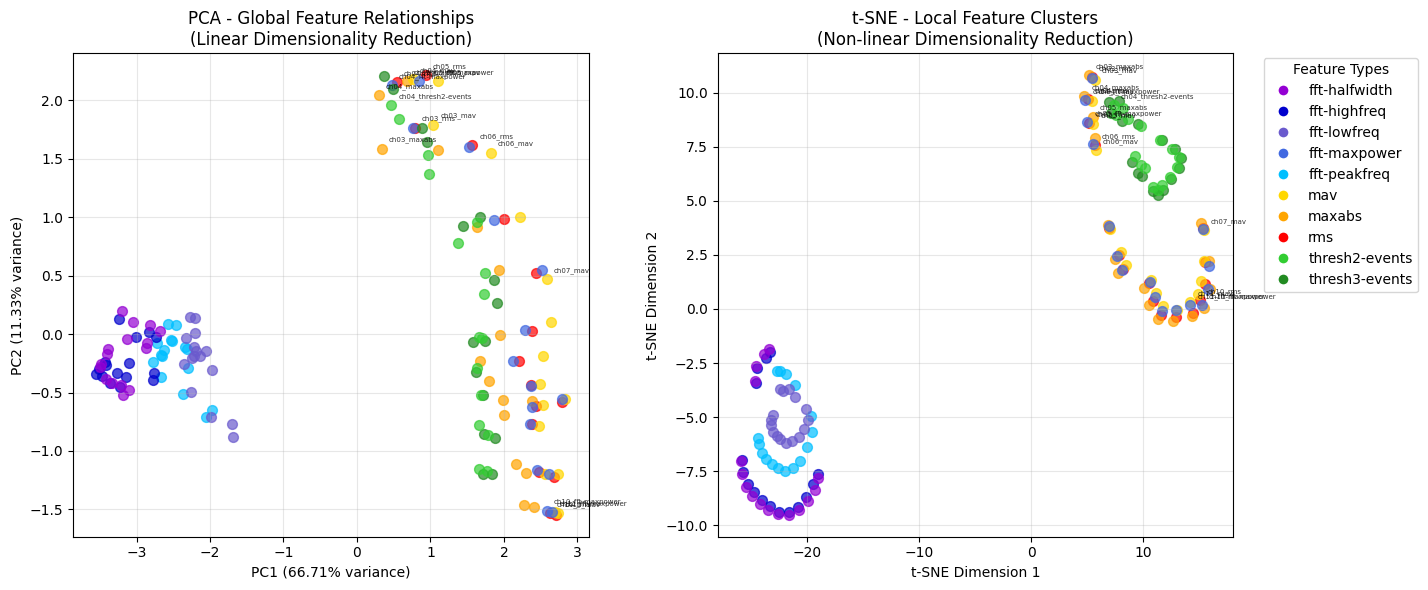

In [14]:
# Create combined figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6))

# LEFT: PCA 
for i, feature in enumerate(feature_cols):
    ax1.scatter(feature_pca_results[i, 0], feature_pca_results[i, 1], 
               c=feature_colors[i], alpha=0.7, s=50)
    
    # Label important features
    importance = feature_importance_df[feature_importance_df['feature'] == feature]['importance'].values[0]
    if importance > 0.01:
        ax1.annotate(feature, (feature_pca_results[i, 0], feature_pca_results[i, 1]),
                    xytext=(5, 5), textcoords='offset points', fontsize=5, alpha=0.8)

ax1.set_xlabel(f'PC1 ({pca_features.explained_variance_ratio_[0]:.2%} variance)')
ax1.set_ylabel(f'PC2 ({pca_features.explained_variance_ratio_[1]:.2%} variance)')
ax1.set_title('PCA - Global Feature Relationships\n(Linear Dimensionality Reduction)', fontsize=12)
ax1.grid(True, alpha=0.3)

# RIGHT: t-SNE
for i, feature in enumerate(feature_cols):
    ax2.scatter(feature_tsne_results[i, 0], feature_tsne_results[i, 1], 
               c=feature_colors[i], alpha=0.7, s=50)
    
    # Label important features
    importance = feature_importance_df[feature_importance_df['feature'] == feature]['importance'].values[0]
    if importance > 0.01:
        ax2.annotate(feature, (feature_tsne_results[i, 0], feature_tsne_results[i, 1]),
                    xytext=(5, 5), textcoords='offset points', fontsize=5, alpha=0.8)

ax2.set_xlabel('t-SNE Dimension 1')
ax2.set_ylabel('t-SNE Dimension 2')
ax2.set_title('t-SNE - Local Feature Clusters\n(Non-linear Dimensionality Reduction)', fontsize=12)
ax2.grid(True, alpha=0.3)

# Create unified legend
sorted_feature_types = sorted(feature_color_map.keys())
legend_elements = [Line2D([0], [0], marker='o', color='w', 
                         markerfacecolor=feature_color_map[feature_type], 
                         markersize=8, label=feature_type) 
                  for feature_type in sorted_feature_types]

# Add legend to the figure (not to individual axes)
fig.legend(handles=legend_elements, title='Feature Types',
          loc='center right', bbox_to_anchor=(1.1, 0.7))

plt.tight_layout()
plt.show()

### Correlation analysis of top features

Found: 91 highly correlated feature pairs (r > 0.9)
Some highly correlated features:
  ch05_rms <-> ch05_maxabs: 0.960
  ch05_rms <-> ch05_mav: 0.984
  ch05_rms <-> ch05_fft-maxpower: 0.938
  ch05_maxabs <-> ch05_mav: 0.912
  ch04_rms <-> ch04_fft-maxpower: 0.921


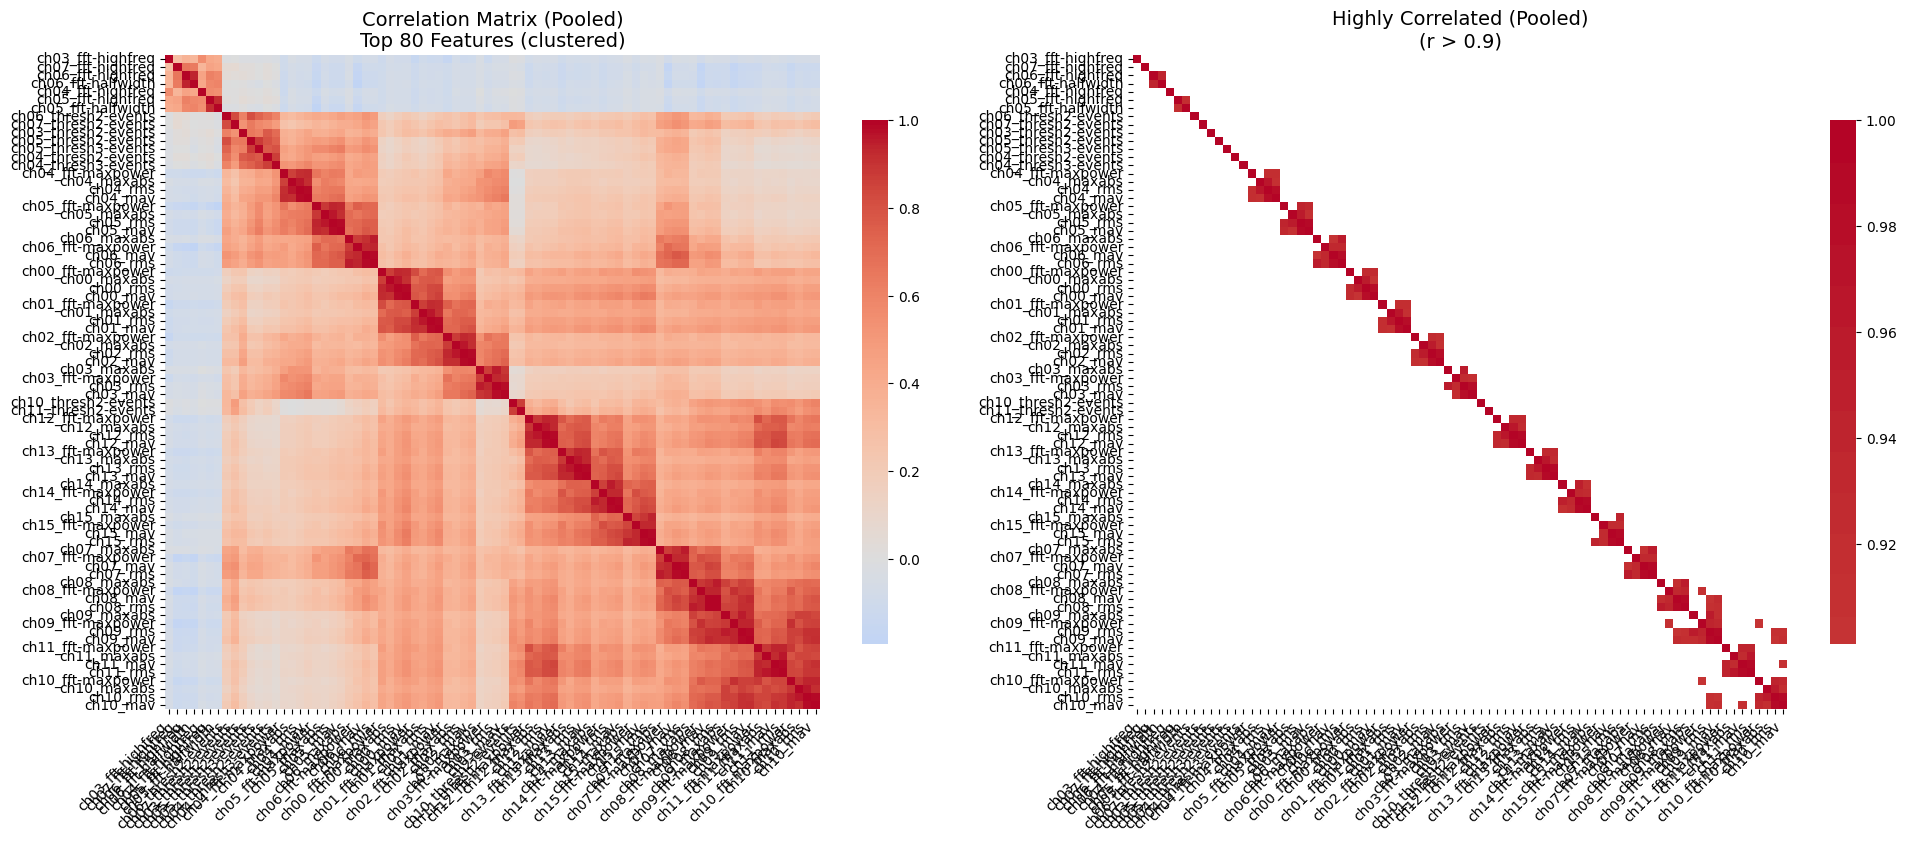

In [15]:
# Check for highly correlated features among top features — POOLED

# Look at top N features (N = STARTING_POOL_SIZE)
topN_features = feature_importance_df.head(STARTING_POOL_SIZE)['feature'].tolist()

# Calculate pooled correlations between top features
correlation_matrix = df_no_outliers[topN_features].corr()

# Find highly correlated pairs (r > CORRELATION_THRESHOLD)
high_corr_pairs = []
cols = correlation_matrix.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        corr_value = abs(correlation_matrix.iloc[i, j])
        if corr_value > CORRELATION_THRESHOLD:
            high_corr_pairs.append((cols[i], cols[j], corr_value))

print(f"Found: {len(high_corr_pairs)} highly correlated feature pairs (r > {CORRELATION_THRESHOLD})")
if high_corr_pairs:
    print("Some highly correlated features:")
    for feat1, feat2, corr in high_corr_pairs[:5]:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")

#- Visualization: SIDE BY SIDE with hierarchical clustering-
# Use the SAME top N for readability
topN_for_corr = feature_importance_df.head(STARTING_POOL_SIZE)['feature'].tolist()
corr_topN = df_no_outliers[topN_for_corr].corr()

# Hierarchical clustering order (distance = 1 - |corr|)
dist = 1.0 - np.abs(corr_topN.values)
# Convert to condensed form and cluster
Z = linkage(squareform(dist, checks=False), method='average')
order = leaves_list(Z)
ordered_cols = corr_topN.columns[order]
corr_ord = corr_topN.loc[ordered_cols, ordered_cols]

# Create figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Left plot: Full correlation matrix (clustered, no numbers)
sns.heatmap(
    corr_ord,
    cmap='coolwarm',
    center=0,
    annot=False,      # keep style: no numbers on the left
    square=True,
    cbar_kws={'shrink': 0.8},
    ax=ax1
)
ax1.set_title(f'Correlation Matrix (Pooled)\nTop {STARTING_POOL_SIZE} Features (clustered)', fontsize=14)
# Force all ticks/labels to show (no skipping)
ax1.set_xticks(np.arange(len(ordered_cols))+0.5)
ax1.set_yticks(np.arange(len(ordered_cols))+0.5)
ax1.set_xticklabels(ordered_cols, rotation=45, ha='right')
ax1.set_yticklabels(ordered_cols, rotation=0)

# Right plot: Only highly correlated cells (clustered, NO numbers)
mask_thresh = np.abs(corr_ord) <= CORRELATION_THRESHOLD
sns.heatmap(
    corr_ord.where(~mask_thresh),  # keep only > threshold
    cmap='coolwarm',
    center=0,
    annot=False,            # ← remove numbers in the boxes as requested
    square=True,
    cbar_kws={'shrink': 0.8},
    mask=mask_thresh,       # hide non-correlated cells
    ax=ax2
)
ax2.set_title(f'Highly Correlated (Pooled)\n(r > {CORRELATION_THRESHOLD})', fontsize=14)
ax2.set_xticks(np.arange(len(ordered_cols))+0.5)
ax2.set_yticks(np.arange(len(ordered_cols))+0.5)
ax2.set_xticklabels(ordered_cols, rotation=45, ha='right')
ax2.set_yticklabels(ordered_cols, rotation=0)

plt.tight_layout()
plt.show()


In [16]:
# Check for highly correlated features among top features

# Look at top 50 features
top_50_features = feature_importance_df.head(50)['feature'].tolist()

# Calculate correlations between top features
correlation_matrix = df_no_outliers[top_50_features].corr()

# Find features that are very similar (correlation > CORRELATION_THRESHOLD)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = abs(correlation_matrix.iloc[i, j])
        if corr_value > CORRELATION_THRESHOLD:  # Was 0.8, now 0.7 (more aggressive removal)
            feat1 = correlation_matrix.columns[i]
            feat2 = correlation_matrix.columns[j]
            high_corr_pairs.append((feat1, feat2, corr_value))

print(f"Found: {len(high_corr_pairs)} highly correlated feature pairs (r > {CORRELATION_THRESHOLD})")

if high_corr_pairs:
    print("Some highly correlated features:")
    for feat1, feat2, corr in high_corr_pairs[:5]:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")

Found: 62 highly correlated feature pairs (r > 0.9)
Some highly correlated features:
  ch05_rms <-> ch05_maxabs: 0.960
  ch05_rms <-> ch05_mav: 0.984
  ch05_rms <-> ch05_fft-maxpower: 0.938
  ch05_maxabs <-> ch05_mav: 0.912
  ch04_rms <-> ch04_fft-maxpower: 0.921


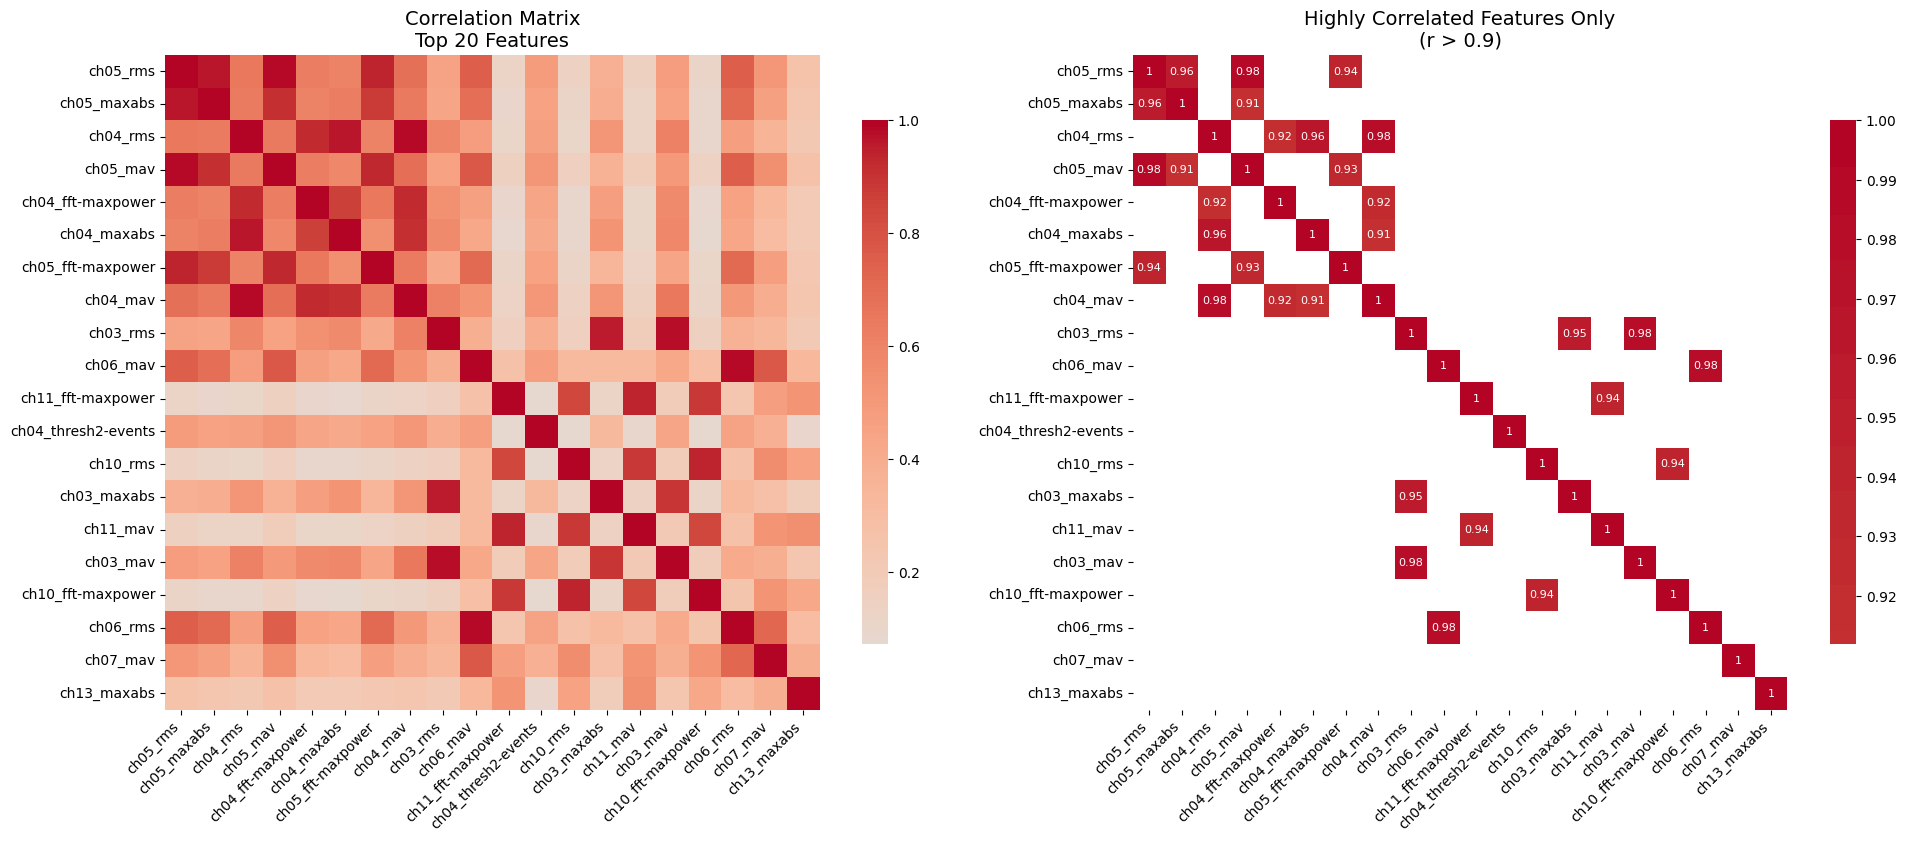

In [17]:
# Visualize correlation matrix of top features - SIDE BY SIDE

# Use top 20 features for the correlation matrix (easier to read)
top_20_for_corr = feature_importance_df.head(20)['feature'].tolist()

# Calculate correlation matrix for top 20 features
corr_matrix_top20 = df_no_outliers[top_20_for_corr].corr()

# Create figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Left plot: Full correlation matrix
sns.heatmap(corr_matrix_top20, 
            cmap='coolwarm', 
            center=0,
            annot=False,  # No numbers for cleaner look
            square=True,
            cbar_kws={'shrink': 0.8},
            ax=ax1)
ax1.set_title('Correlation Matrix\nTop 20 Features', fontsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# Right plot: Only highly correlated pairs
high_corr_matrix = corr_matrix_top20.where(np.abs(corr_matrix_top20) > CORRELATION_THRESHOLD)

sns.heatmap(high_corr_matrix, 
            cmap='coolwarm', 
            center=0,
            annot=True,  # Show numbers for high correlations
            square=True,
            cbar_kws={'shrink': 0.8},
            mask=high_corr_matrix.isnull(),  # Hide non-correlated cells
            annot_kws={'size': 8}, 
            ax=ax2)
ax2.set_title(f'Highly Correlated Features Only\n(r > {CORRELATION_THRESHOLD})', fontsize=14)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [18]:
# Print some statistics for top features
print(f"Total feature pairs: {len(corr_matrix_top20.columns) * (len(corr_matrix_top20.columns) - 1) // 2}")
print(f"Highly correlated pairs (r > {CORRELATION_THRESHOLD}): {len(high_corr_pairs)}")
print(f"Very highly correlated pairs (r > 0.9): {len([pair for pair in high_corr_pairs if pair[2] > 0.9])}")

Total feature pairs: 190
Highly correlated pairs (r > 0.9): 62
Very highly correlated pairs (r > 0.9): 62


## Personalized

### ⏳ Random forest for feature importance

In [19]:
# Calculate feature importance for EACH USER individually
all_user_results = {}

for user_id in df_train['user'].unique():
    # Get this user's data only
    user_data = df_train[df_train['user'] == user_id]
    
    # Prepare features and target for this user
    X_user = user_data[feature_cols].copy()
    y_user = user_data['gesture']
    
    # Train Random Forest for this specific user
    rf_user = RandomForestClassifier(
        n_estimators=100,
        random_state=13,
        # max_depth=15,
        n_jobs=-1
    )
    rf_user.fit(X_user, y_user)
    
    # Get feature importance for this user
    user_importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf_user.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Store results
    all_user_results[user_id] = user_importance_df
    
    # Clean up
    del X_user, y_user, rf_user

### Top features

In [20]:
# Build per_user_stats_df
feature_importance_stats = {}

for feature in feature_cols:
    scores = []
    for user_id, user_imp_df in all_user_results.items():
        s = user_imp_df.loc[user_imp_df['feature'] == feature, 'importance']
        if len(s) > 0:
            scores.append(float(s.iloc[0]))

    if len(scores) > 0:
        scores = np.asarray(scores, dtype=float)
        mean_val   = float(np.mean(scores))
        median_val = float(np.median(scores))
        std_val    = float(np.std(scores, ddof=0))
        n_scored   = int(len(scores))
    else:
        # keep row to avoid downstream NaNs
        mean_val   = 0.0
        median_val = 0.0
        std_val    = 0.0
        n_scored   = 0

    feature_importance_stats[feature] = {
        'mean':   mean_val,
        'median': median_val,
        'std':    std_val,
        'n_users_with_score': n_scored
    }

per_user_stats_df = pd.DataFrame.from_dict(feature_importance_stats, orient='index')

# Preview
per_user_stats_df.head()

mean    median       std  n_users_with_score
ch00_rms  0.007816  0.007247  0.002844                 100
ch01_rms  0.008050  0.007368  0.003236                 100
ch02_rms  0.010236  0.008854  0.005791                 100
ch03_rms  0.013725  0.012061  0.006518                 100
ch04_rms  0.016798  0.016100  0.007060                 100

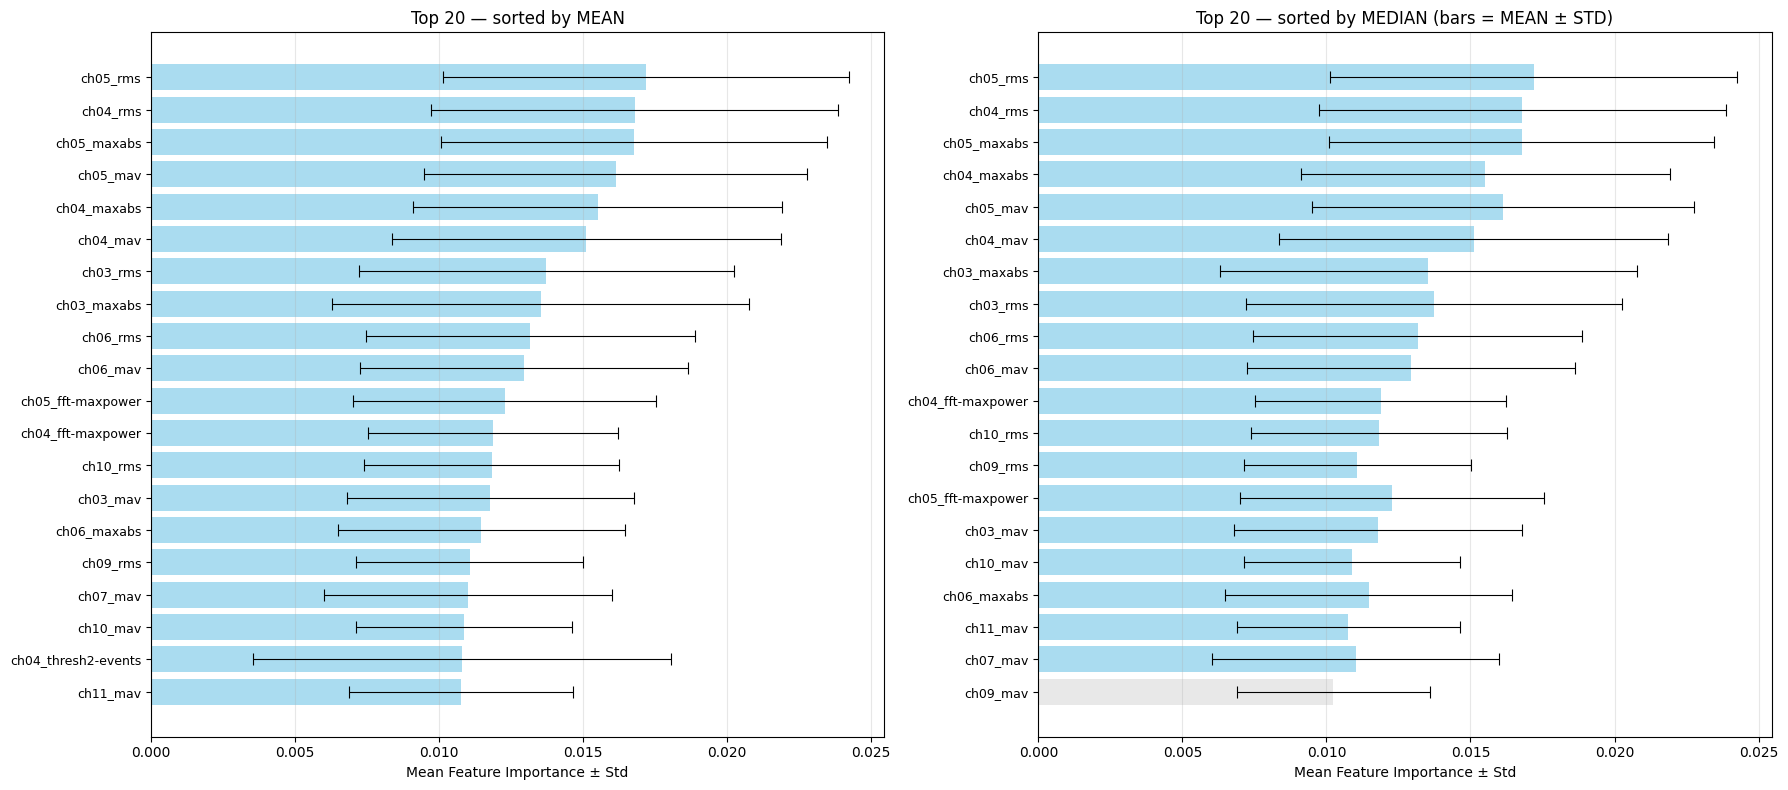

In [21]:
# Display Top 20 by MEAN (sorted by mean)
# AND Top 20 by MEDIAN (bars still show MEAN ± STD; sorted by median)

# Prepare subsets
top20_mean   = per_user_stats_df.sort_values('mean',   ascending=False).head(20).copy()
top20_median = per_user_stats_df.sort_values('median', ascending=False).head(20).copy()

fig, (axB, axC) = plt.subplots(1, 2, figsize=(18, 8))

# Top 20 by MEAN
yB = list(top20_mean.index)
xB = top20_mean['mean'].values
eB = top20_mean['std'].values
cB = ['skyblue' for _ in yB]  # all in top-20-by-mean → skyblue
aB = [0.7 for _ in yB]

barsB = axB.barh(yB, xB, xerr=eB, color=cB, capsize=4,
                 error_kw={'elinewidth': 0.8, 'capthick': 0.8})
for b, a in zip(barsB, aB):
    b.set_alpha(a)

axB.invert_yaxis()
axB.set_title('Top 20 — sorted by MEAN', fontsize=12)
axB.set_xlabel('Mean Feature Importance ± Std')
axB.grid(True, axis='x', alpha=0.3)

axB.yaxis.set_major_locator(mticker.FixedLocator(np.arange(len(yB))))
axB.set_yticks(np.arange(len(yB)))
axB.set_yticklabels(yB, fontsize=9)

# Top 20 by MEDIAN (bars show MEAN ± STD)
yC = list(top20_median.index)
xC = per_user_stats_df.loc[yC, 'mean'].values
eC = per_user_stats_df.loc[yC, 'std'].values
# color by "is feature in the global top-20-by-mean?"
cC = ['skyblue' if f in top20_mean.index else 'lightgray' for f in yC]
aC = [0.7 if clr == 'skyblue' else 0.5 for clr in cC]

barsC = axC.barh(yC, xC, xerr=eC, color=cC, capsize=4,
                 error_kw={'elinewidth': 0.8, 'capthick': 0.8})
for b, a in zip(barsC, aC):
    b.set_alpha(a)

axC.invert_yaxis()
axC.set_title('Top 20 — sorted by MEDIAN (bars = MEAN ± STD)', fontsize=12)
axC.set_xlabel('Mean Feature Importance ± Std')
axC.grid(True, axis='x', alpha=0.3)

axC.yaxis.set_major_locator(mticker.FixedLocator(np.arange(len(yC))))
axC.set_yticks(np.arange(len(yC)))
axC.set_yticklabels(yC, fontsize=9)

plt.tight_layout()
plt.show()


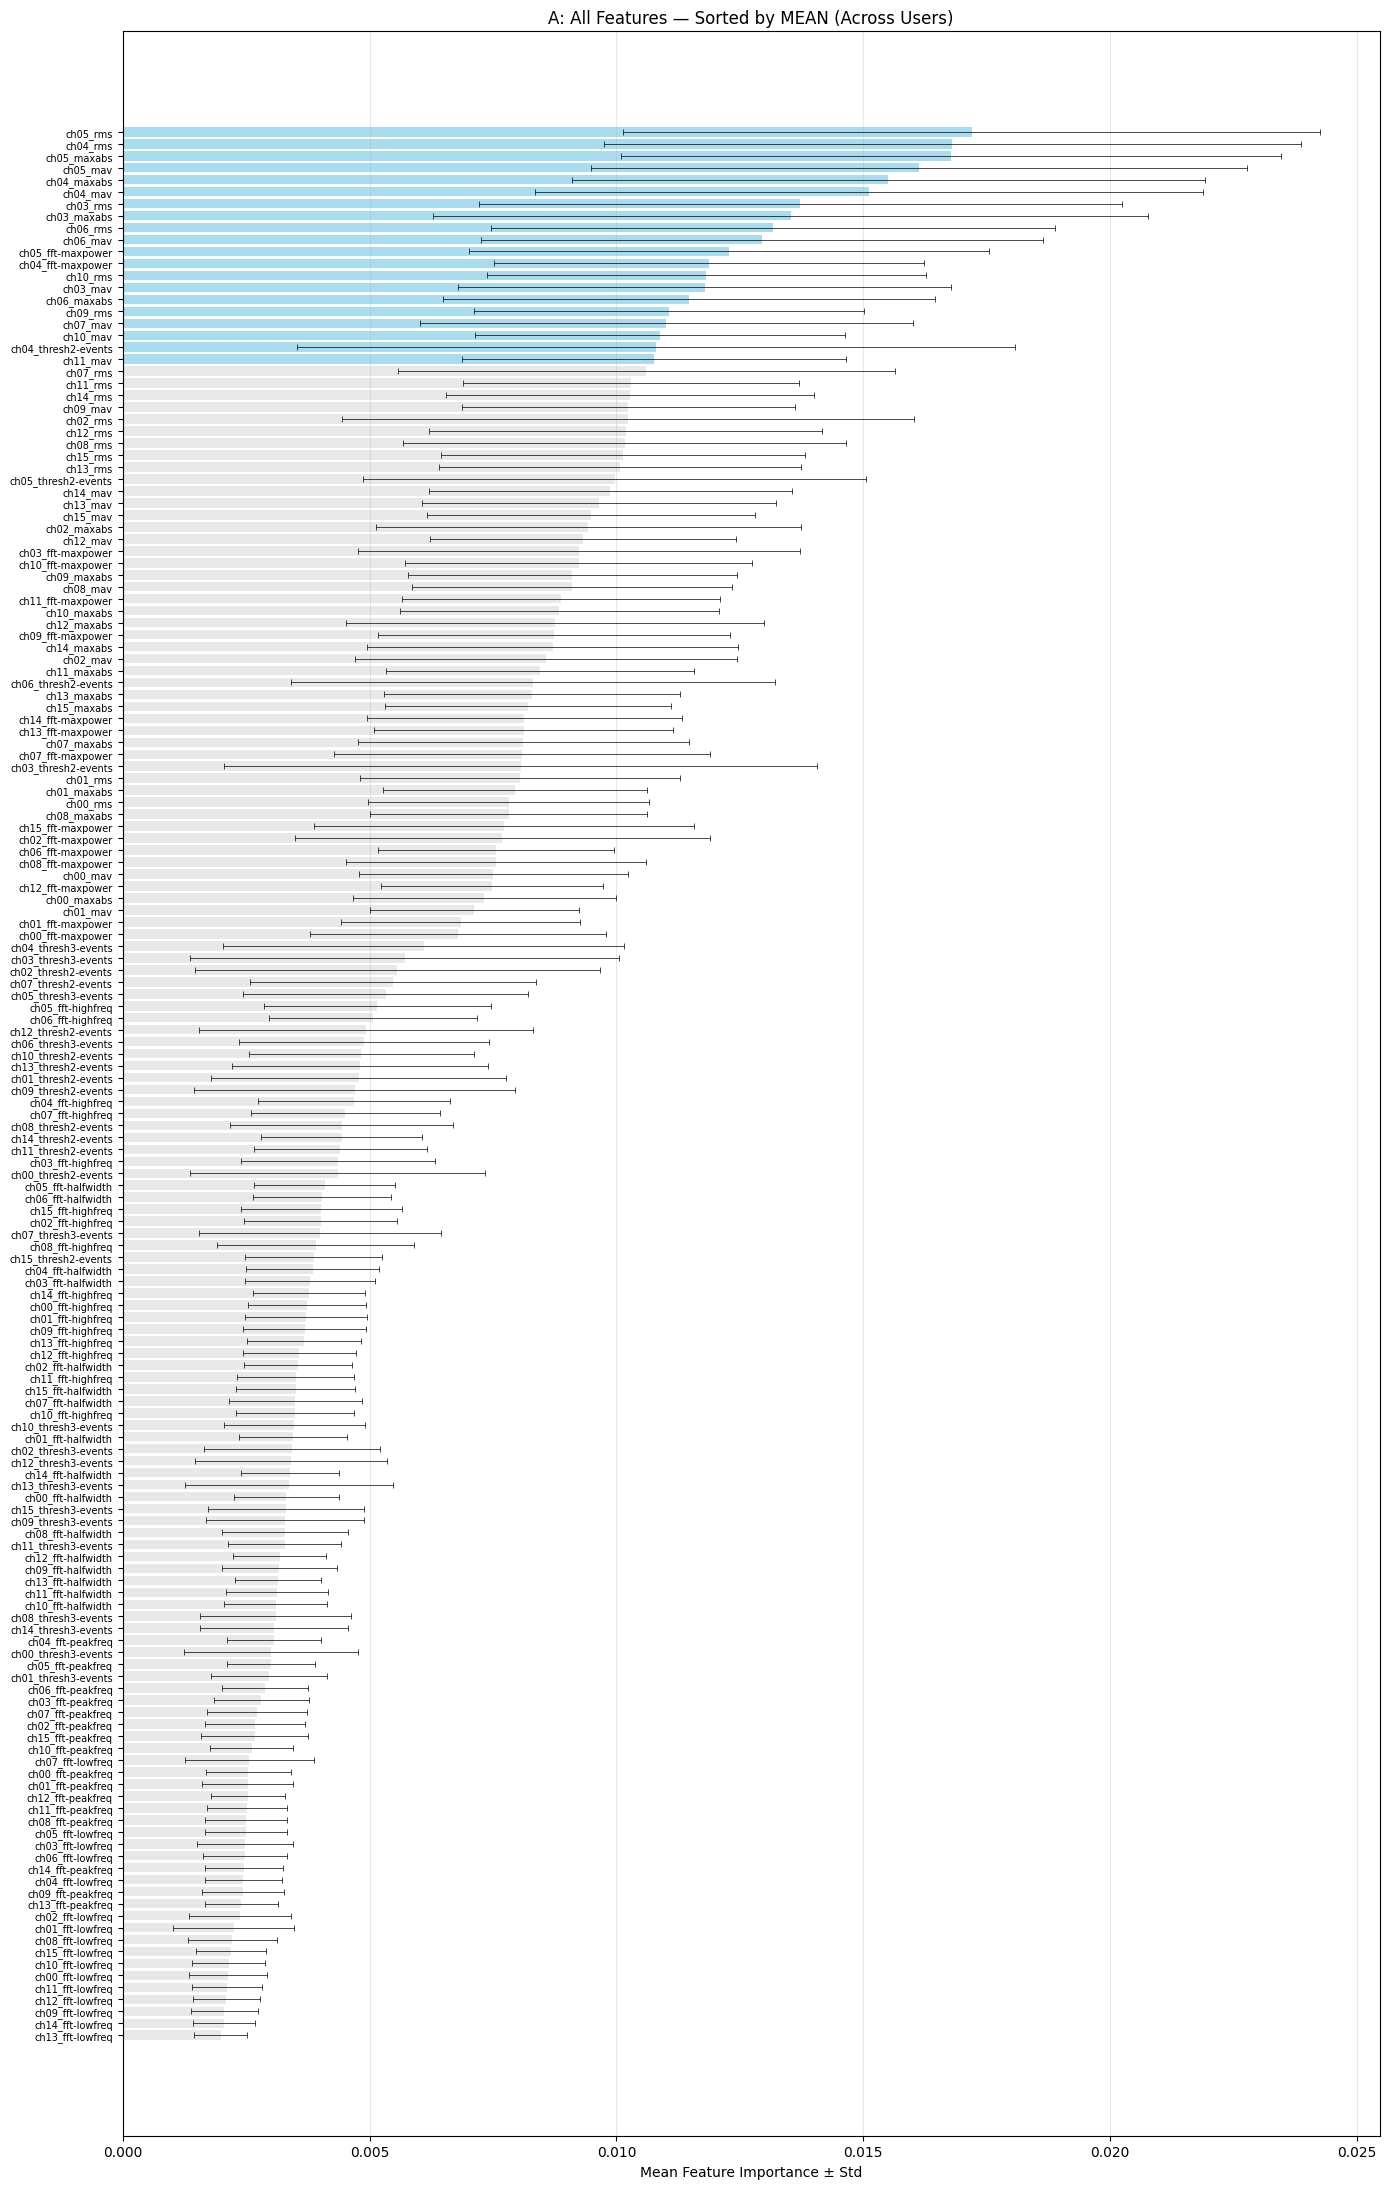

In [22]:
# Display all features, sorted by MEAN

# skyblue if the feature is in Top 20 by mean, else lightgray
def color_for_feature(feature_name):
    return 'skyblue' if feature_name in top20_mean.index else 'lightgray'

all_sorted_mean = per_user_stats_df.sort_values('mean', ascending=False).copy()

fig, axA = plt.subplots(figsize=(14, 22))  # taller to fit 160 labels

y_labels = list(all_sorted_mean.index)
x_vals   = all_sorted_mean['mean'].values
x_errs   = all_sorted_mean['std'].values
colorsA  = [color_for_feature(f) for f in y_labels]
alphasA  = [0.7 if c == 'skyblue' else 0.5 for c in colorsA]

# Horizontal bars with error bars
barsA = axA.barh(y_labels, x_vals, xerr=x_errs, color=colorsA, capsize=2,
                 error_kw={'elinewidth': 0.5, 'capthick': 0.5})

# per-bar alpha
for b, a in zip(barsA, alphasA):
    b.set_alpha(a)

# Highest at top
axA.invert_yaxis()

axA.set_title('A: All Features — Sorted by MEAN (Across Users)', fontsize=12)
axA.set_xlabel('Mean Feature Importance ± Std')
axA.grid(True, axis='x', alpha=0.3)

# Ensure every y tick is shown (no auto-pruning)
axA.yaxis.set_major_locator(mticker.FixedLocator(np.arange(len(y_labels))))
axA.set_yticks(np.arange(len(y_labels)))
axA.set_yticklabels(y_labels, fontsize=7)

plt.tight_layout()
plt.show()

### Channel importance

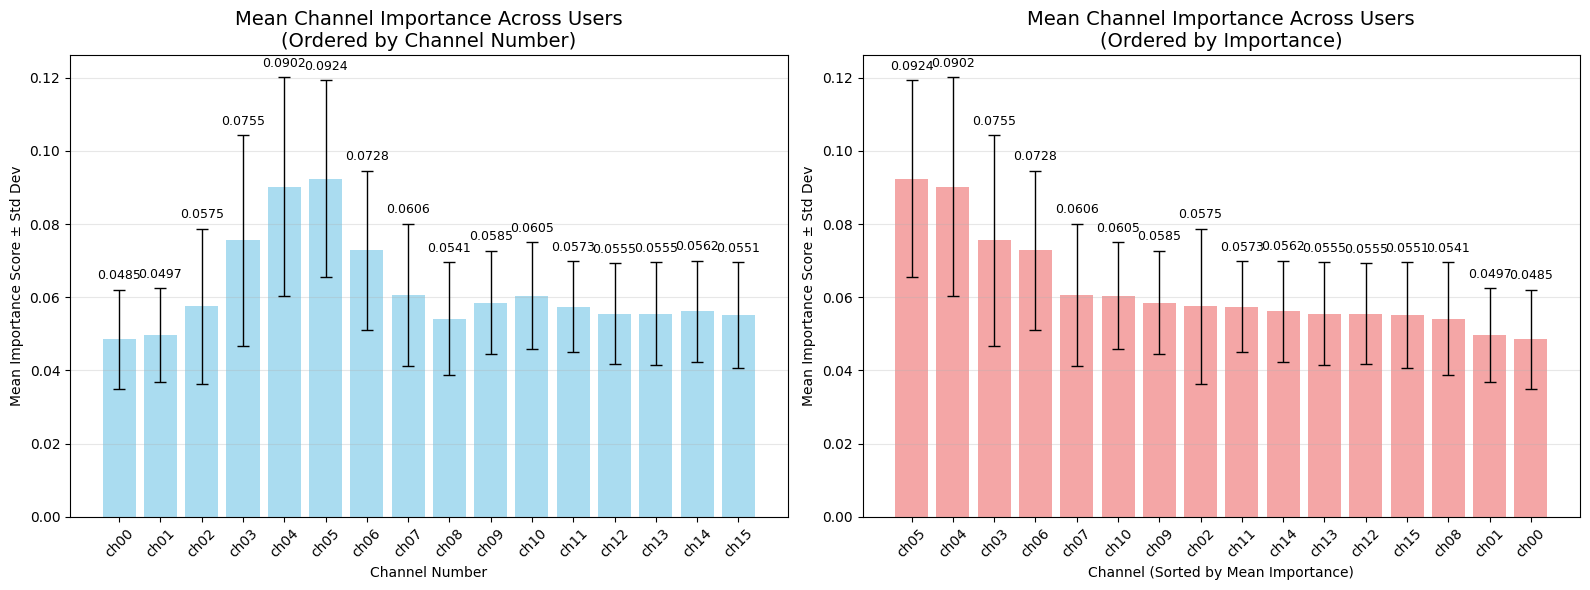

In [23]:
# PER-USER CHANNEL IMPORTANCE 

# Dictionary to store channel importance for each user
user_channel_importance = {}

# Calculate channel importance for each user individually
for user_id, user_importance_df in all_user_results.items():
    channel_importance_user = {}
    
    # Go through every feature and add up importance by channel for this user
    for i, row in user_importance_df.iterrows():
        feature_name = row['feature']
        importance_score = row['importance']
        
        # Extract channel number from feature name
        if 'ch' in feature_name:
            # Find channel number part
            start_index = feature_name.find('ch') + 2
            channel_num = ''
            
            # Read numbers after 'ch'
            for char in feature_name[start_index:]:
                if char.isdigit():
                    channel_num += char
                else:
                    break
            
            if channel_num:
                channel_name = f"ch{channel_num}"
                
                # Add this feature's importance to channel total for this user
                if channel_name in channel_importance_user:
                    channel_importance_user[channel_name] += importance_score
                else:
                    channel_importance_user[channel_name] = importance_score
    
    user_channel_importance[user_id] = channel_importance_user

# Calculate mean and std of channel importance across all users
channel_importance_stats = {}

# Make sure we have all channels from ch00 to ch15
all_channels = [f"ch{str(i).zfill(2)}" for i in range(16)]

for channel in all_channels:
    importance_scores = []
    for user_id, channel_imp_user in user_channel_importance.items():
        if channel in channel_imp_user:
            importance_scores.append(channel_imp_user[channel])
    
    if importance_scores:
        channel_importance_stats[channel] = {
            'mean': np.mean(importance_scores),
            'std': np.std(importance_scores),
            'cv': np.std(importance_scores) / np.mean(importance_scores) if np.mean(importance_scores) > 0 else 0
        }
    else:
        channel_importance_stats[channel] = {
            'mean': 0,
            'std': 0,
            'cv': 0
        }

# Sort by channel number
channels_by_number = sorted(channel_importance_stats.keys())
mean_by_number = [channel_importance_stats[ch]['mean'] for ch in channels_by_number]
std_by_number = [channel_importance_stats[ch]['std'] for ch in channels_by_number]

# Sort by mean importance (highest to lowest)
channels_by_importance = sorted(channel_importance_stats.keys(), 
                               key=lambda x: channel_importance_stats[x]['mean'], 
                               reverse=True)
mean_by_importance = [channel_importance_stats[ch]['mean'] for ch in channels_by_importance]
std_by_importance = [channel_importance_stats[ch]['std'] for ch in channels_by_importance]

# Create two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# LEFT PLOT: Ordered by channel number (with error bars)
bars1 = ax1.bar(channels_by_number, mean_by_number, color='skyblue', alpha=0.7,
                yerr=std_by_number, capsize=4, error_kw={'elinewidth': 1, 'capthick': 1})
ax1.set_title('Mean Channel Importance Across Users\n(Ordered by Channel Number)', fontsize=14)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Mean Importance Score ± Std Dev')
ax1.tick_params(axis='x', rotation=45)

# Add numbers on top of bars (mean values)
for bar, mean_imp, std_imp in zip(bars1, mean_by_number, std_by_number):
    if mean_imp > 0:  # Only label bars with non-zero importance
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + std_imp + 0.002,
                f'{mean_imp:.4f}', ha='center', va='bottom', fontsize=9)

# Add grid for easier reading
ax1.grid(True, alpha=0.3, axis='y')

# RIGHT PLOT: Ordered by importance (highest to lowest) with error bars
bars2 = ax2.bar(channels_by_importance, mean_by_importance, color='lightcoral', alpha=0.7,
                yerr=std_by_importance, capsize=4, error_kw={'elinewidth': 1, 'capthick': 1})
ax2.set_title('Mean Channel Importance Across Users\n(Ordered by Importance)', fontsize=14)
ax2.set_xlabel('Channel (Sorted by Mean Importance)')
ax2.set_ylabel('Mean Importance Score ± Std Dev')
ax2.tick_params(axis='x', rotation=45)

# Add numbers on top of bars (mean values)
for bar, mean_imp, std_imp in zip(bars2, mean_by_importance, std_by_importance):
    if mean_imp > 0:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + std_imp + 0.002,
                f'{mean_imp:.4f}', ha='center', va='bottom', fontsize=9)

ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### ⏳ PCA & t-SNE

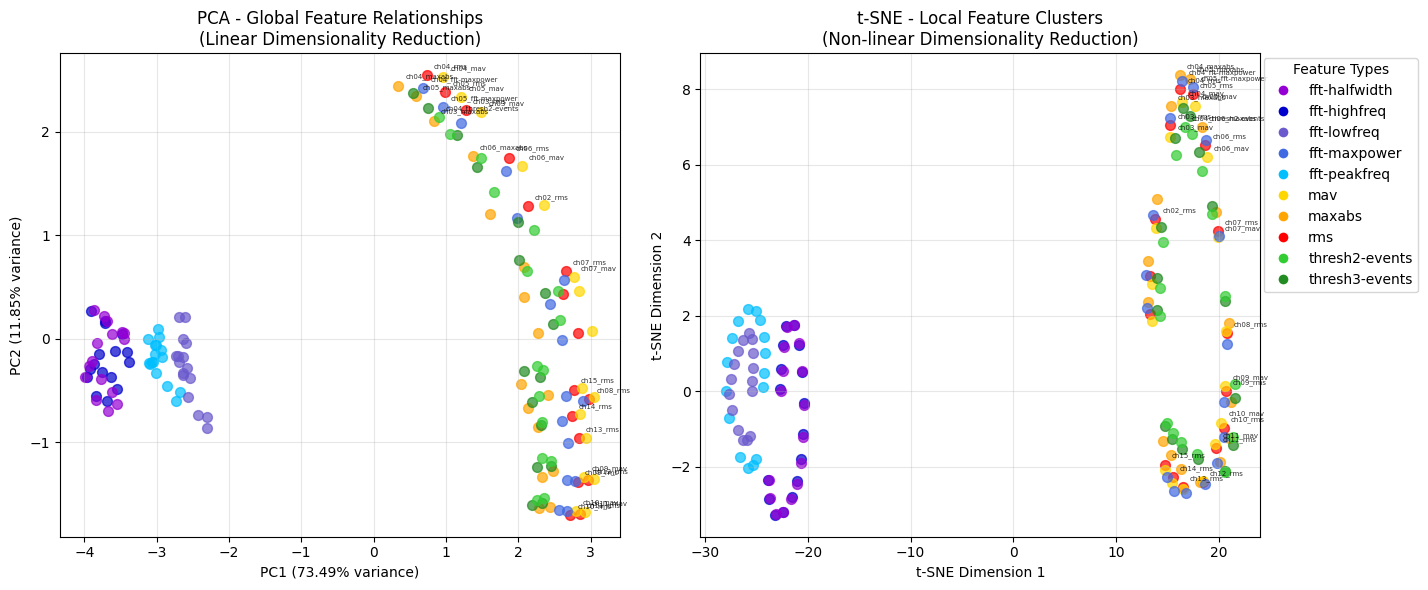

In [24]:
# PER-USER DIMENSIONALITY REDUCTION: FEATURE SIMILARITY VARIABILITY

# Color scheme for feature types
feature_color_map = {
    'fft-halfwidth': 'darkviolet',
    'fft-highfreq': 'mediumblue', 
    'fft-lowfreq': 'slateblue',
    'fft-maxpower': 'royalblue',
    'fft-peakfreq': 'deepskyblue',
    'mav': 'gold',
    'maxabs': 'orange',
    'rms': 'red',
    'thresh2-events': 'limegreen',
    'thresh3-events': 'forestgreen'
}

# Prepare feature colors
feature_colors = [feature_color_map[feature.split('_', 1)[1]] for feature in feature_cols]

# Calculate mean correlation matrix across users
user_correlation_stacks = []

for user_id in all_user_results.keys():
    user_data = df_train[df_train['user'] == user_id]
    if len(user_data) > 1:  # Need at least 2 samples for correlation
        user_corr_matrix = user_data[feature_cols].corr().values
        user_correlation_stacks.append(user_corr_matrix)

mean_correlation_matrix = np.mean(user_correlation_stacks, axis=0)

# Run PCA on mean correlation matrix
pca_features = PCA(n_components=2)
feature_pca_results = pca_features.fit_transform(mean_correlation_matrix)

# Run t-SNE on mean correlation matrix (with caching)
tsne_results_file = "../data/processed/tsne_feature_results_per_user.npy"
if os.path.exists(tsne_results_file):
    feature_tsne_results = np.load(tsne_results_file)
else:   
    tsne_features = TSNE(n_components=2, random_state=13, perplexity=30)
    feature_tsne_results = tsne_features.fit_transform(mean_correlation_matrix)
    np.save(tsne_results_file, feature_tsne_results)

# Create combined figure for per-user analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

# LEFT: PCA on Mean User Correlations
for i, feature in enumerate(feature_cols):
    ax1.scatter(feature_pca_results[i, 0], feature_pca_results[i, 1], 
               c=feature_colors[i], alpha=0.7, s=50)
    
    # Label features with high mean importance across users
    mean_importance = per_user_stats_df.loc[feature, 'mean']
    if mean_importance > 0.01:
        ax1.annotate(feature, (feature_pca_results[i, 0], feature_pca_results[i, 1]),
                    xytext=(5, 5), textcoords='offset points', fontsize=5, alpha=0.8)

ax1.set_xlabel(f'PC1 ({pca_features.explained_variance_ratio_[0]:.2%} variance)')
ax1.set_ylabel(f'PC2 ({pca_features.explained_variance_ratio_[1]:.2%} variance)')
ax1.set_title('PCA - Global Feature Relationships\n(Linear Dimensionality Reduction)', fontsize=12)
ax1.grid(True, alpha=0.3)

# RIGHT: t-SNE on Mean User Correlations
for i, feature in enumerate(feature_cols):
    ax2.scatter(feature_tsne_results[i, 0], feature_tsne_results[i, 1], 
               c=feature_colors[i], alpha=0.7, s=50)
    
    # Label features with high mean importance across users
    mean_importance = per_user_stats_df.loc[feature, 'mean']
    if mean_importance > 0.01:
        ax2.annotate(feature, (feature_tsne_results[i, 0], feature_tsne_results[i, 1]),
                    xytext=(5, 5), textcoords='offset points', fontsize=5, alpha=0.8)

ax2.set_xlabel('t-SNE Dimension 1')
ax2.set_ylabel('t-SNE Dimension 2')
ax2.set_title('t-SNE - Local Feature Clusters\n(Non-linear Dimensionality Reduction)', fontsize=12)
ax2.grid(True, alpha=0.3)

# Create unified legend
sorted_feature_types = sorted(feature_color_map.keys())
legend_elements = [Line2D([0], [0], marker='o', color='w', 
                         markerfacecolor=feature_color_map[feature_type], 
                         markersize=8, label=feature_type) 
                  for feature_type in sorted_feature_types]

# Add legend to figure
fig.legend(handles=legend_elements, title='Feature Types',
          loc='center right', bbox_to_anchor=(1.1, 0.7))

plt.tight_layout()
plt.show()

In [25]:
# See which feature types have most variance in PCA
pca_feature_types = {}

# Go through each feature and group by type (rms, fft, etc.)
for i, feature in enumerate(feature_cols):
    # Get part after "chXX_"
    feature_type = feature.split('_', 1)[1]
    if feature_type not in pca_feature_types:
        pca_feature_types[feature_type] = []
    # Save PC1 value for this feature
    pca_feature_types[feature_type].append(feature_pca_results[i, 0])

# Check which feature types vary the most in PC1
print("Variance in PC1 by feature type (higher numbers => more info):")
for feature_type, pc1_values in pca_feature_types.items():
    variance = np.var(pc1_values)
    print(f"  {feature_type}: {variance:.4f}")

Variance in PC1 by feature type (higher numbers => more info):
  rms: 0.5145
  maxabs: 0.4529
  mav: 0.4501
  fft-peakfreq: 0.0148
  fft-maxpower: 0.4608
  fft-highfreq: 0.0315
  fft-lowfreq: 0.0158
  fft-halfwidth: 0.0284
  thresh3-events: 0.3542
  thresh2-events: 0.2476


### Feature vs. trial covariance

Current approach explained variance: [0.53979604 0.13348235]
Trial covariance approach explained variance: [0.68302909 0.10526396] (5000 samples)


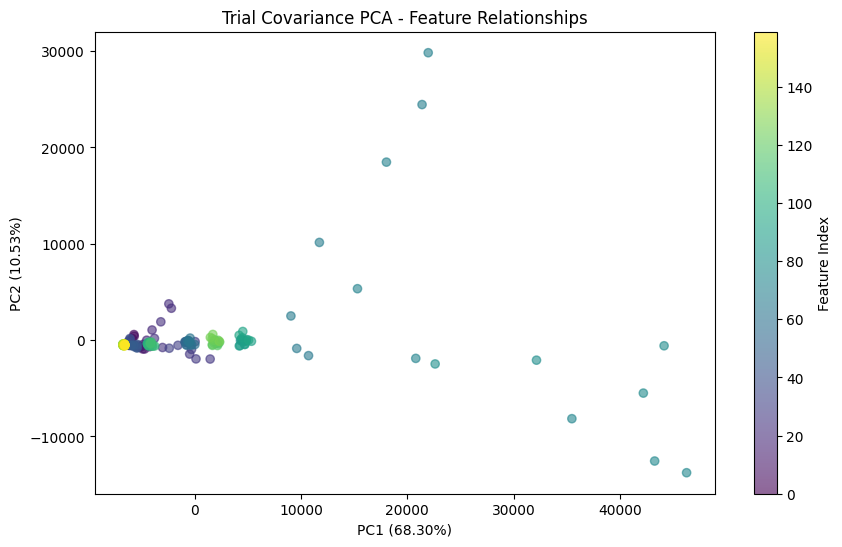

In [26]:
# Testing different PCA approaches

# Current approach: Feature covariance
feature_matrix = df_no_outliers[feature_cols].values
pca_features_current = PCA(n_components=2)
feature_pca_current = pca_features_current.fit_transform(feature_matrix)
print(f"Current approach explained variance: {pca_features_current.explained_variance_ratio_}")

# Trying trial covariance method
# Using only 5000 samples
sample_size = min(5000, feature_matrix.shape[0])
feature_matrix_sample = feature_matrix[:sample_size, :]

# transposing matrix
pca_trials = PCA(n_components=2)
trial_pca_results = pca_trials.fit_transform(feature_matrix_sample.T)
print(f"Trial covariance approach explained variance: {pca_trials.explained_variance_ratio_} ({sample_size} samples)")

# plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(trial_pca_results[:, 0], trial_pca_results[:, 1], 
                     c=range(trial_pca_results.shape[0]), cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Feature Index')
plt.xlabel(f'PC1 ({pca_trials.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca_trials.explained_variance_ratio_[1]:.2%})')
plt.title('Trial Covariance PCA - Feature Relationships')
plt.show()

### Correlation analysis of top features

Found: 87 highly correlated feature pairs (r > 0.9)
Some highly correlated features:
  ch05_rms <-> ch05_maxabs: 0.955
  ch05_rms <-> ch05_mav: 0.987
  ch05_rms <-> ch05_fft-maxpower: 0.926
  ch04_rms <-> ch04_maxabs: 0.958
  ch04_rms <-> ch04_mav: 0.986


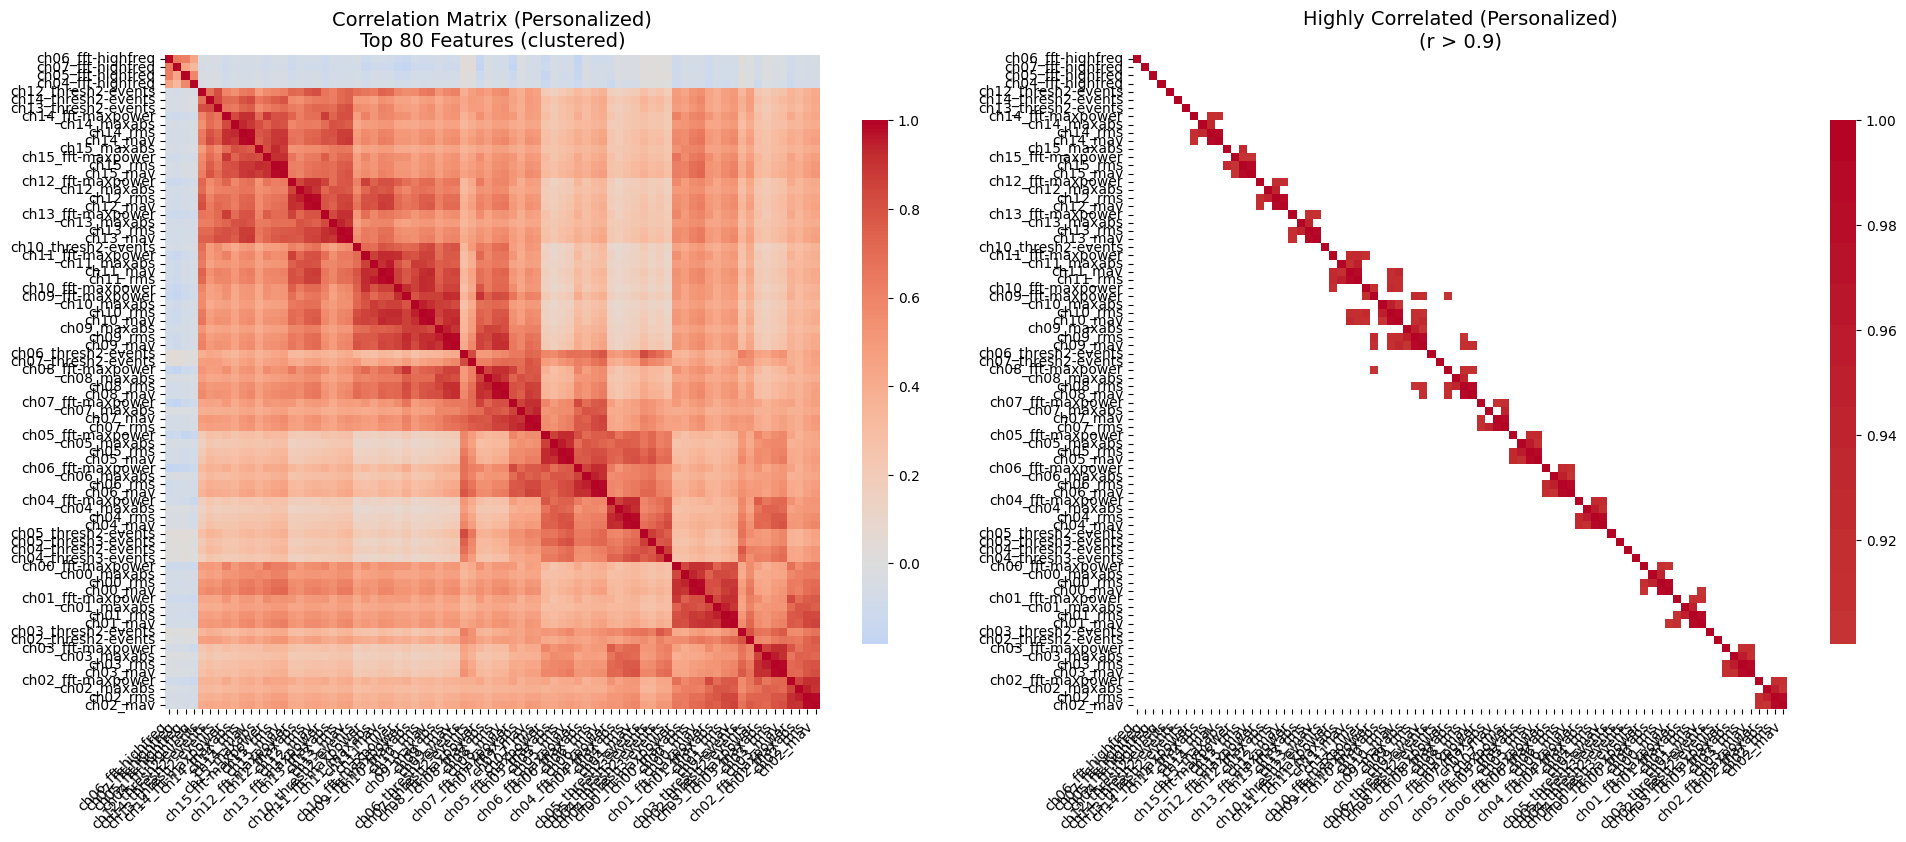

In [27]:
# Personalized / per-user correlation analysis of top features — PERSONALIZED

# Build personalized train-only correlation matrix
user_corrs = []
for uid in sorted(df_train['user'].unique()):
    sub = df_train[df_train['user'] == uid]
    if len(sub) > 3:
        user_corrs.append(sub[feature_cols].corr().values)

corr_arr = np.nanmean(np.stack(user_corrs, axis=0), axis=0)
corr_df = pd.DataFrame(corr_arr, index=feature_cols, columns=feature_cols)

# Choose ranking column (personalization-first uses MEDIAN)
rank_col = 'median' if 'median' in per_user_stats_df.columns else 'mean'

# Top N by personalized importance (N = STARTING_POOL_SIZE)
topN_features = (
    per_user_stats_df
    .sort_values(rank_col, ascending=False)
    .head(STARTING_POOL_SIZE)
    .index
    .tolist()
)

# Personalized correlation among top-N (use the SAME corr_df as pruning)
correlation_matrix = corr_df.loc[topN_features, topN_features]

# Find highly correlated pairs (r > CORRELATION_THRESHOLD)
high_corr_pairs = []
cols = correlation_matrix.columns
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        corr_value = abs(float(correlation_matrix.iloc[i, j]))
        if corr_value > CORRELATION_THRESHOLD:
            high_corr_pairs.append((cols[i], cols[j], corr_value))

print(f"Found: {len(high_corr_pairs)} highly correlated feature pairs (r > {CORRELATION_THRESHOLD})")
if high_corr_pairs:
    print("Some highly correlated features:")
    for feat1, feat2, corr in high_corr_pairs[:5]:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")

# Plots: SIDE BY SIDE with hierarchical clustering
# Use SAME top N for matrix
topN_for_corr = (
    per_user_stats_df
    .sort_values(rank_col, ascending=False)
    .head(STARTING_POOL_SIZE)
    .index
    .tolist()
)
corr_topN = corr_df.loc[topN_for_corr, topN_for_corr]

# Hierarchical clustering order (distance = 1 - |corr|)
dist = 1.0 - np.abs(corr_topN.values)
Z = linkage(squareform(dist, checks=False), method='average')
order = leaves_list(Z)
ordered_cols = corr_topN.columns[order]
corr_ord = corr_topN.loc[ordered_cols, ordered_cols]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Left plot: full correlation matrix (clustered, no numbers)
sns.heatmap(
    corr_ord,
    cmap='coolwarm',
    center=0,
    annot=False,  
    square=True,
    cbar_kws={'shrink': 0.8},
    ax=ax1
)
ax1.set_title(f'Correlation Matrix (Personalized)\nTop {STARTING_POOL_SIZE} Features (clustered)', fontsize=14)
ax1.set_xticks(np.arange(len(ordered_cols))+0.5)
ax1.set_yticks(np.arange(len(ordered_cols))+0.5)
ax1.set_xticklabels(ordered_cols, rotation=45, ha='right')
ax1.set_yticklabels(ordered_cols, rotation=0)

# Right plot: only highly correlated cells (clustered, NO numbers)
mask_thresh = np.abs(corr_ord) <= CORRELATION_THRESHOLD
sns.heatmap(
    corr_ord.where(~mask_thresh),
    cmap='coolwarm',
    center=0,
    annot=False,  
    square=True,
    cbar_kws={'shrink': 0.8},
    mask=mask_thresh,
    ax=ax2
)
ax2.set_title(f'Highly Correlated (Personalized)\n(r > {CORRELATION_THRESHOLD})', fontsize=14)
ax2.set_xticks(np.arange(len(ordered_cols))+0.5)
ax2.set_yticks(np.arange(len(ordered_cols))+0.5)
ax2.set_xticklabels(ordered_cols, rotation=45, ha='right')
ax2.set_yticklabels(ordered_cols, rotation=0)

plt.tight_layout()
plt.show()

In [28]:
# Check if thresh2 and thresh3 are similar
threshold_features = [f for f in feature_cols if 'thresh' in f]
if threshold_features:
    # look at first few channels to keep it simple
    thresh2_features = [f for f in threshold_features if 'thresh2' in f][:3]
    thresh3_features = [f for f in threshold_features if 'thresh3' in f][:3]
    
    for thresh2 in thresh2_features:
        for thresh3 in thresh3_features:
            if thresh2 in df_no_outliers.columns and thresh3 in df_no_outliers.columns:
                corr_val = df_no_outliers[thresh2].corr(df_no_outliers[thresh3])
                print(f"{thresh2.split('_')[0]} {thresh2.split('_')[1]} <-> {thresh3.split('_')[1]}: {corr_val:.3f}")

ch00 thresh2-events <-> thresh3-events: 0.832
ch00 thresh2-events <-> thresh3-events: 0.767
ch00 thresh2-events <-> thresh3-events: 0.663
ch01 thresh2-events <-> thresh3-events: 0.789
ch01 thresh2-events <-> thresh3-events: 0.836
ch01 thresh2-events <-> thresh3-events: 0.761
ch02 thresh2-events <-> thresh3-events: 0.684
ch02 thresh2-events <-> thresh3-events: 0.768
ch02 thresh2-events <-> thresh3-events: 0.845


## Remove redundant features

In [29]:
# Personalized redundancy pruning (do NOT rebuild corr_df)

# Keep only features that appear in correlation matrix
stats_tbl = per_user_stats_df.copy()
common_idx = stats_tbl.index.intersection(corr_df.index)
stats_tbl = stats_tbl.loc[common_idx].copy()

# Choose ranking column: prefer 'median' (more robust per-user), else fall back to 'mean'
rank_col = 'median' if 'median' in stats_tbl.columns else 'mean'

# Seed list: top-N by personalized importance (N = STARTING_POOL_SIZE)
top_features = (
    stats_tbl
    .sort_values(rank_col, ascending=False)
    .head(int(STARTING_POOL_SIZE))
    .index
    .tolist()
)

# Pruning: if candidate is highly correlated with anything already kept,
# keep the one with higher personalized importance (by rank_col)
final_features = []

for f in top_features:
    keep_f = True
    for g in final_features:
        # If either feature missing from corr_df, treat as uncorrelated
        if (f in corr_df.index and g in corr_df.index and
            f in corr_df.columns and g in corr_df.columns):
            rho = float(abs(corr_df.loc[f, g]))
        else:
            rho = 0.0

        if rho > float(CORRELATION_THRESHOLD):
            # Conflict: keep higher-ranked by rank_col
            if float(stats_tbl.loc[f, rank_col]) > float(stats_tbl.loc[g, rank_col]):
                # Replace g with f
                final_features.remove(g)
                final_features.append(f)
                print(f" Replaced {g} with {f} (|r|={rho:.2f} > {CORRELATION_THRESHOLD}; {rank_col} improved)")
            # Either way, we've handled f vs g; don't add f again
            keep_f = False
            break

    if keep_f and f not in final_features:
        final_features.append(f)

print(f"{len(final_features)} features after removing redundant features "
      f"(seed={len(top_features)}, thr={CORRELATION_THRESHOLD}, rank={rank_col}).")

# Category summary for sanity checking
feature_categories = {
    'FFT Features': [],
    'RMS Features': [],
    'MAV Features': [],
    'Max Features': [],
    'Threshold Features': []
}
for feat in final_features:
    fl = feat.lower()
    if 'fft' in fl:
        feature_categories['FFT Features'].append(feat)
    elif 'rms' in fl:
        feature_categories['RMS Features'].append(feat)
    elif 'mav' in fl:
        feature_categories['MAV Features'].append(feat)
    elif 'max' in fl:
        feature_categories['Max Features'].append(feat)
    elif 'thresh' in fl:
        feature_categories['Threshold Features'].append(feat)

for cat, feats in feature_categories.items():
    if feats:
        print(f"\n{cat} ({len(feats)}):")
        for feat in sorted(feats):
            print(f"  - {feat} (importance={stats_tbl.loc[feat, rank_col]:.4f})")

37 features after removing redundant features (seed=80, thr=0.9, rank=median).

FFT Features (7):
  - ch03_fft-maxpower (importance=0.0081)
  - ch04_fft-highfreq (importance=0.0044)
  - ch05_fft-highfreq (importance=0.0046)
  - ch06_fft-highfreq (importance=0.0047)
  - ch07_fft-highfreq (importance=0.0043)
  - ch09_fft-maxpower (importance=0.0082)
  - ch11_fft-maxpower (importance=0.0082)

RMS Features (11):
  - ch00_rms (importance=0.0072)
  - ch02_rms (importance=0.0089)
  - ch04_rms (importance=0.0161)
  - ch05_rms (importance=0.0163)
  - ch06_rms (importance=0.0118)
  - ch08_rms (importance=0.0093)
  - ch10_rms (importance=0.0109)
  - ch12_rms (importance=0.0091)
  - ch13_rms (importance=0.0094)
  - ch14_rms (importance=0.0096)
  - ch15_rms (importance=0.0096)

MAV Features (2):
  - ch01_mav (importance=0.0067)
  - ch07_mav (importance=0.0099)

Max Features (5):
  - ch01_maxabs (importance=0.0075)
  - ch03_maxabs (importance=0.0123)
  - ch07_maxabs (importance=0.0072)
  - ch09_maxa

## Visualization of final feature set

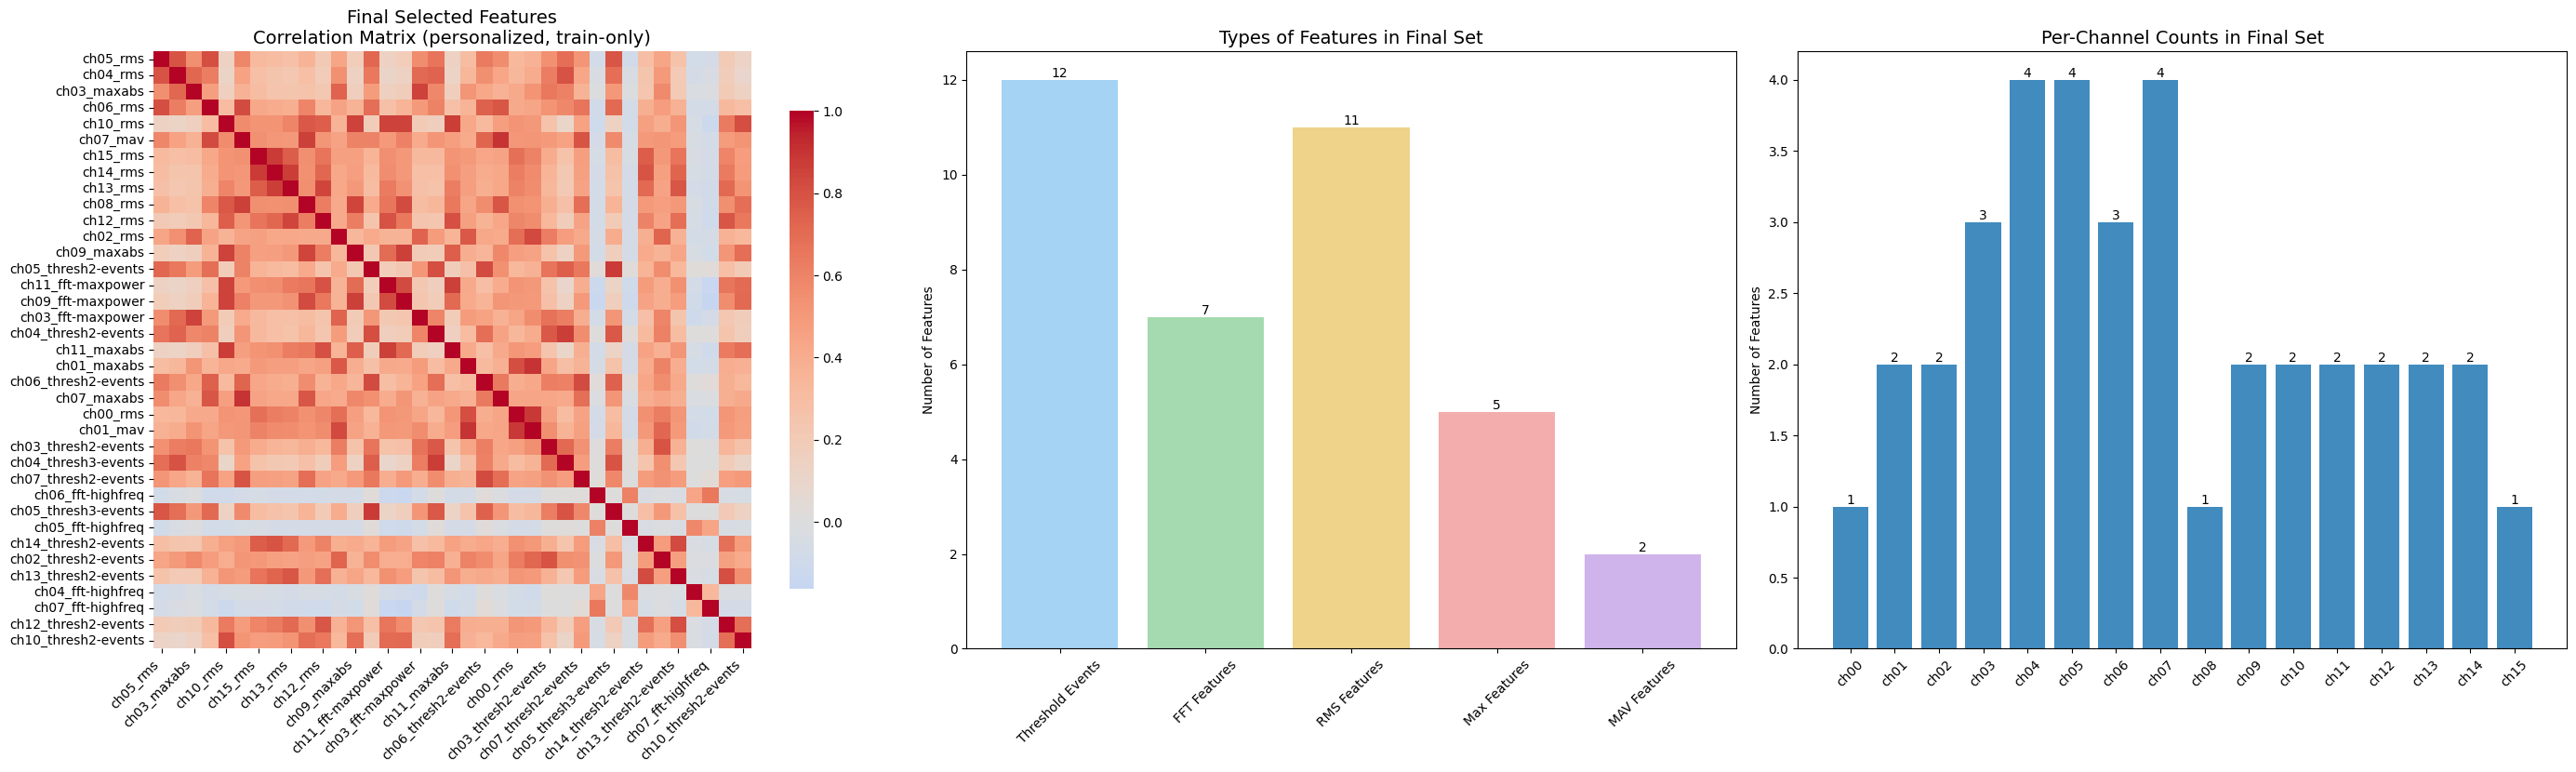

In [30]:
# Simple visualization of semi-/final feature selection results

# Create figure with 3 subplots side by side
fig, (a1, a2, a3) = plt.subplots(1, 3, figsize=(28, 8))

# Plot: Correlation matrix of final selected features (WITH numbers)
# Re-use SAME train-only correlation matrix used for redundancy pruning: corr_df

# Intersect with columns we actually have
final_cols = [c for c in final_features if c in corr_df.columns]
final_corr_matrix = corr_df.loc[final_cols, final_cols]
sns.heatmap(
    final_corr_matrix,
    cmap="coolwarm", center=0,
    # annot=True, fmt=".2f",                # numbers in the squares
    square=True,
    cbar_kws={"shrink": 0.8},
    ax=a1
)
a1.set_title("Final Selected Features\nCorrelation Matrix (personalized, train-only)", fontsize=14)
a1.set_xticklabels(a1.get_xticklabels(), rotation=45, ha="right")
a1.set_yticklabels(a1.get_yticklabels(), rotation=0)

# Plot: Feature types breakdown
categories_order = ["Threshold Events", "FFT Features", "RMS Features", "Max Features", "MAV Features"]

feature_type_counts = {k: 0 for k in categories_order}

for f in final_features:
    fl = f.lower()
    if "thresh" in fl:
        feature_type_counts["Threshold Events"] += 1
    elif "fft" in fl:
        feature_type_counts["FFT Features"] += 1
    elif "rms" in fl:
        feature_type_counts["RMS Features"] += 1
    elif "maxabs" in fl:
        feature_type_counts["Max Features"] += 1
    elif "mav" in fl:
        feature_type_counts["MAV Features"] += 1

types  = categories_order
counts = [feature_type_counts[t] for t in types]
colors = ["#8EC9F0", "#8FD19E", "#EBC86E", "#F19999", "#C3A1E6"]  # 1:1 with categories_order

bars = a2.bar(types, counts, color=colors, alpha=0.8)
a2.set_title("Types of Features in Final Set", fontsize=14)
a2.set_ylabel("Number of Features")
a2.tick_params(axis="x", rotation=45)

# Add labels on top of bars
for b in bars:
    h = b.get_height()
    a2.text(b.get_x() + b.get_width()/2., h, f"{int(h)}", ha="center", va="bottom")

# Plot: Counts per channel (show ALL channels 0...15)
# Change prefixes like "ch03" or "3" to "ch03"
def _norm_ch(prefix):
    p = prefix.lower()
    if p.startswith('ch'):
        try:
            return f"ch{int(p[2:]):02d}"
        except ValueError:
            return None
    # numeric-only prefix (e.g., "3" or "15")
    if p.isdigit():
        return f"ch{int(p):02d}"
    return None  # ignore anything that doesn't match known scheme

# channel list ch00...ch15
all_channels = [f"ch{i:02d}" for i in range(16)]

# Count selected features per channel
channel_counts = {ch: 0 for ch in all_channels}
for f in final_features:
    prefix = f.split('_', 1)[0]  # get text before first underscore
    ch = _norm_ch(prefix)
    if ch in channel_counts:
        channel_counts[ch] += 1
    # else: ignore non-matching prefixes

chan_vals = [channel_counts[ch] for ch in all_channels]

bars3 = a3.bar(all_channels, chan_vals, alpha=0.85)
a3.set_title("Per-Channel Counts in Final Set", fontsize=14)
a3.set_ylabel("Number of Features")
a3.tick_params(axis="x", rotation=45)

# Annotate counts on top of bars
for b in bars3:
    h = b.get_height()
    a3.text(b.get_x() + b.get_width()/2., h, f"{int(h)}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

In [31]:
# Summary
print("Final Feature Selection")
print(f"- Started with: {len(feature_cols)} total features")
print(f"- Selected: {len(final_features)} features")
for k in categories_order:
    print(f"  - {k}: {feature_type_counts[k]}")

Final Feature Selection
- Started with: 160 total features
- Selected: 37 features
  - Threshold Events: 12
  - FFT Features: 7
  - RMS Features: 11
  - Max Features: 5
  - MAV Features: 2


### Pairplots

In [32]:
# Pairplots of semi-/final features (personalized only)

# Choose ranking column
rank_col = 'median' if 'median' in per_user_stats_df.columns else 'mean'

# Use ALL selected semi-/final features (ranked just for stable order)
all_features_viz = (
    per_user_stats_df.loc[final_features]
    .sort_values(rank_col, ascending=False)
    .index
    .tolist()
)

# print(f"Creating pairplot for {len(all_features_viz)} selected features...")
for i, f in enumerate(all_features_viz, 1):
    imp = per_user_stats_df.loc[f, rank_col] if f in per_user_stats_df.index else float('nan')
    print(f"  {i:2d}. {f} (importance[{rank_col}]: {imp:.4f})")

# Pick a dense sample user
sample_user_id = df_train['user'].value_counts().index[0]

# # Select only columns that exist in df_train for plotting
# plot_cols = [c for c in all_features_viz if c in df_train.columns]
# sample_data = df_train.loc[df_train['user'] == sample_user_id, plot_cols].copy()

# # Plot: ALL selected features pairplot
# title1 = (f'Pairplot: {len(plot_cols)} Selected Features '
#           f'(rank: {rank_col}, user={sample_user_id})')
# g1 = sns.pairplot(
#     sample_data,
#     diag_kind='kde',
#     plot_kws={'alpha': 0.6, 's': 20, 'edgecolor': 'none'},
#     diag_kws={'alpha': 0.8, 'fill': True},
#     corner=False
# )
# g1.fig.suptitle(title1, y=1.02, fontsize=16, fontweight='bold')

# # Add r-values on upper triangle (corr_df only)
# n = len(plot_cols)
# for i in range(n):
#     for j in range(n):
#         if i < j:
#             fi, fj = plot_cols[i], plot_cols[j]
#             if (fi in corr_df.index) and (fj in corr_df.columns):
#                 rho = float(corr_df.loc[fi, fj])
#             else:
#                 continue  # skip if either feature missing from corr_df

#             ax = g1.axes[i, j]
#             if abs(rho) > float(CORRELATION_THRESHOLD):
#                 color, weight = 'red', 'bold'
#             elif abs(rho) > 0.4:
#                 color, weight = 'orange', 'bold'
#             else:
#                 color, weight = 'black', 'normal'
#             ax.text(
#                 0.5, 0.92, f'r = {rho:.2f}',
#                 transform=ax.transAxes, ha='center', va='center',
#                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9),
#                 fontsize=9, fontweight=weight, color=color
#             )

# plt.tight_layout()
# plt.show()

   1. ch05_rms (importance[median]: 0.0163)
   2. ch04_rms (importance[median]: 0.0161)
   3. ch03_maxabs (importance[median]: 0.0123)
   4. ch06_rms (importance[median]: 0.0118)
   5. ch10_rms (importance[median]: 0.0109)
   6. ch07_mav (importance[median]: 0.0099)
   7. ch15_rms (importance[median]: 0.0096)
   8. ch14_rms (importance[median]: 0.0096)
   9. ch13_rms (importance[median]: 0.0094)
  10. ch08_rms (importance[median]: 0.0093)
  11. ch12_rms (importance[median]: 0.0091)
  12. ch02_rms (importance[median]: 0.0089)
  13. ch09_maxabs (importance[median]: 0.0088)
  14. ch05_thresh2-events (importance[median]: 0.0083)
  15. ch11_fft-maxpower (importance[median]: 0.0082)
  16. ch09_fft-maxpower (importance[median]: 0.0082)
  17. ch03_fft-maxpower (importance[median]: 0.0081)
  18. ch04_thresh2-events (importance[median]: 0.0078)
  19. ch11_maxabs (importance[median]: 0.0077)
  20. ch01_maxabs (importance[median]: 0.0075)
  21. ch06_thresh2-events (importance[median]: 0.0075)
  22

Zoom subset (top by median, present in corr_df & df_train): 37 features
Most correlated pairs in top features:
   1. ch07_mav <-> ch07_maxabs: r = 0.899
   2. ch01_maxabs <-> ch01_mav: r = 0.897
   3. ch00_rms <-> ch01_mav: r = 0.887
   4. ch15_rms <-> ch14_rms: r = 0.881
   5. ch05_thresh2-events <-> ch05_thresh3-events: r = 0.875
   6. ch10_rms <-> ch11_maxabs: r = 0.871


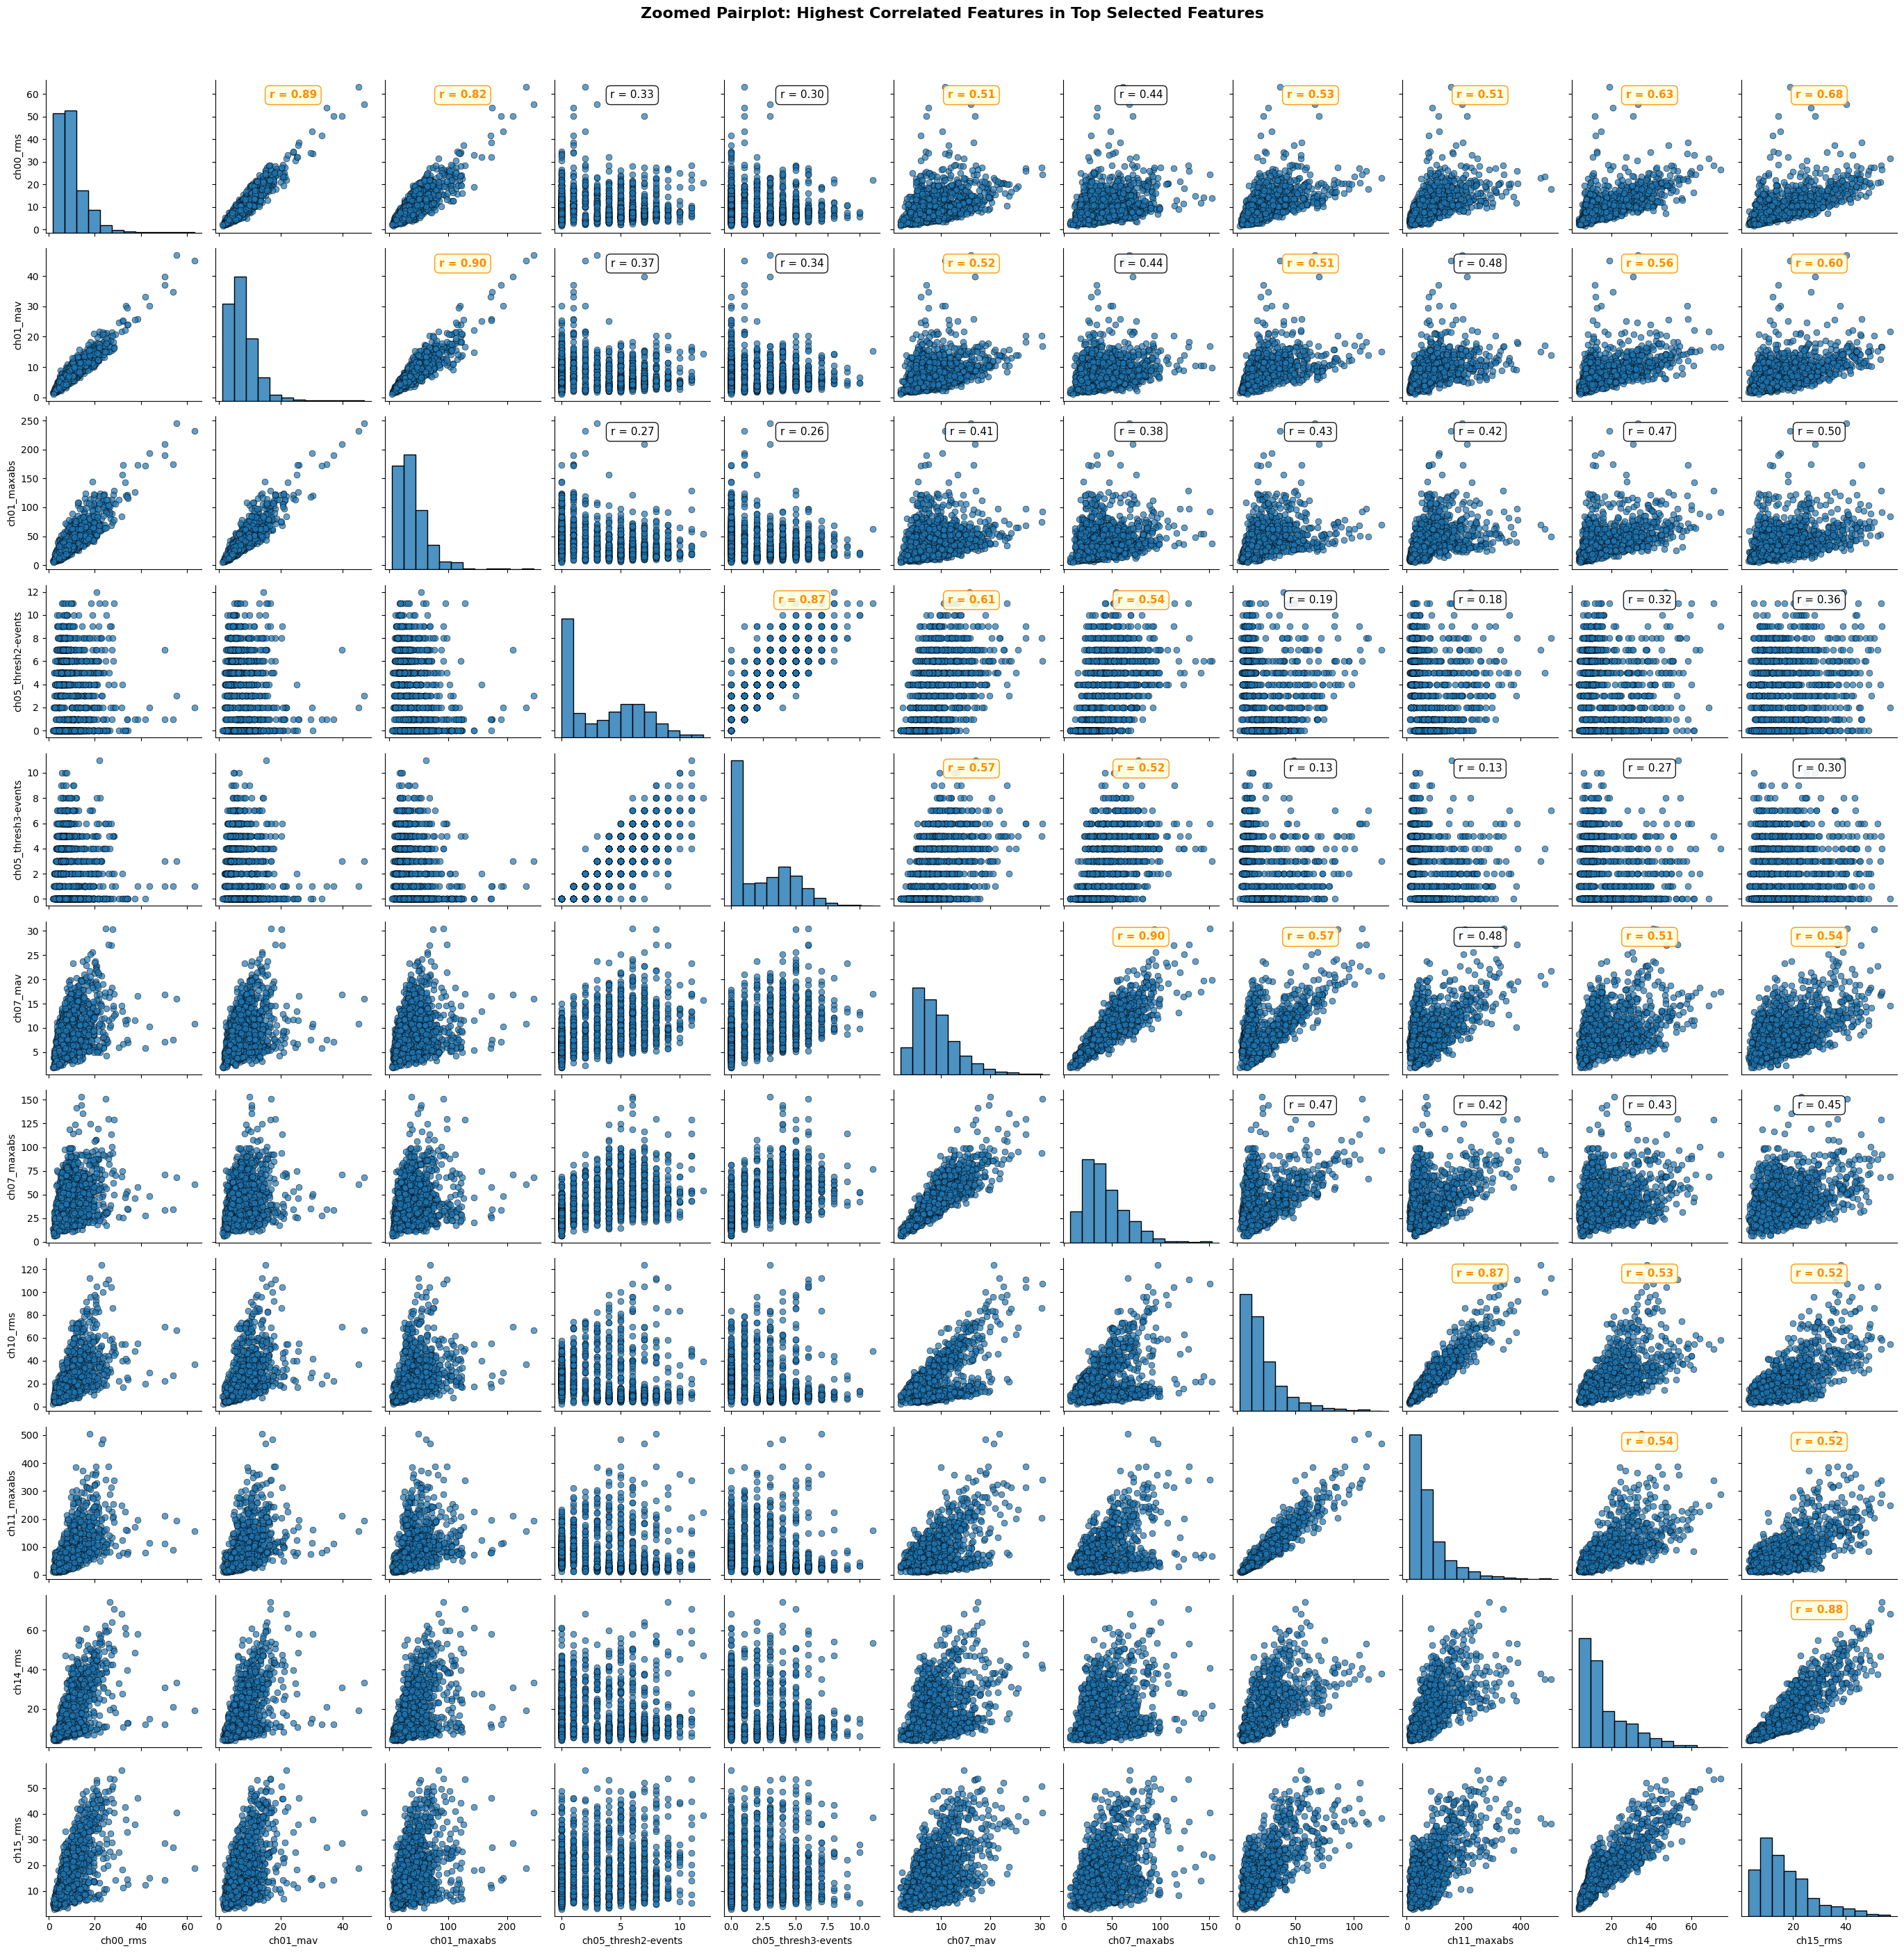

In [33]:
# ZOOM IN on most highly correlated features among top set

# Define "top" subset for zoom: ranked by personalized importance,
# then keep only features present in BOTH corr_df and df_train columns
rank_col = 'median' if 'median' in per_user_stats_df.columns else 'mean'
ranked_all = (
    per_user_stats_df.loc[final_features]
    .sort_values(rank_col, ascending=False)
    .index
    .tolist()
)

top_features_viz = []
for f in ranked_all:
    if (f in corr_df.index) and (f in corr_df.columns) and (f in df_train.columns):
        top_features_viz.append(f)
    if len(top_features_viz) >= int(STARTING_POOL_SIZE):
        break

print(f"Zoom subset (top by {rank_col}, present in corr_df & df_train): {len(top_features_viz)} features")

# Build pair list using corr_df
pairs = []
for i in range(len(top_features_viz)):
    for j in range(i + 1, len(top_features_viz)):
        fi, fj = top_features_viz[i], top_features_viz[j]
        if (fi in corr_df.index) and (fj in corr_df.columns):
            rho = float(abs(corr_df.loc[fi, fj]))
            pairs.append((fi, fj, rho))
        # else: skip pairs not present in corr_df

pairs.sort(key=lambda x: x[2], reverse=True)
above_thr = [p for p in pairs if p[2] > float(CORRELATION_THRESHOLD)]
selected_pairs = above_thr[:6] if len(above_thr) > 0 else pairs[:6]

print("Most correlated pairs in top features:")
for i, (fi, fj, r) in enumerate(selected_pairs, 1):
    print(f"  {i:2d}. {fi} <-> {fj}: r = {r:.3f}")

# Unique features from selected pairs
zoom_feats = sorted(set([p[0] for p in selected_pairs] + [p[1] for p in selected_pairs]))

# Build zoomed dataframe
zoom_cols = [c for c in zoom_feats if c in df_train.columns]
zoom_df = df_train.loc[df_train['user'] == sample_user_id, zoom_cols].copy()

g2 = sns.pairplot(
    zoom_df,
    diag_kind='hist',
    plot_kws={'alpha': 0.7, 's': 40, 'edgecolor': 'black', 'linewidth': 0.5},
    diag_kws={'alpha': 0.8, 'bins': 12},
    corner=False
)
g2.fig.suptitle('Zoomed Pairplot: Highest Correlated Features in Top Selected Features',
                y=1.02, fontsize=16, fontweight='bold')

m = len(zoom_cols)
for i in range(m):
    for j in range(m):
        if i < j:
            fi, fj = zoom_cols[i], zoom_cols[j]
            if (fi in corr_df.index) and (fj in corr_df.columns):
                rho = float(corr_df.loc[fi, fj])
            else:
                rho = float(zoom_df[[fi, fj]].corr().iloc[0, 1])
            ax = g2.axes[i, j]
            if abs(rho) > float(CORRELATION_THRESHOLD):
                color, bg_color, weight = 'red', 'lightcoral', 'bold'
            elif abs(rho) > 0.5:
                color, bg_color, weight = 'darkorange', 'lightyellow', 'bold'
            else:
                color, bg_color, weight = 'black', 'white', 'normal'
            ax.text(
                0.5, 0.9, f'r = {rho:.2f}',
                transform=ax.transAxes, ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.4", facecolor=bg_color, alpha=0.9, edgecolor=color),
                fontsize=11, fontweight=weight, color=color
            )

plt.tight_layout()
plt.show()

## Save outputs

### Feature selection log (feature_selection.csv)

Logs results in a table (results/feature_selection.csv) (as per [02_EDA_feature_selection_and_engineering](https://docs.google.com/document/d/1Kl0Oz5YV63c0b6lbUHhTlcTJ7h4KpRAAGrQZfKX6Zyw/edit?usp=sharing)).

Create a log (table) that explains why each of the 160 features was either KEPT or DROPPED. This log needs to be saved as results/feature_selection.csv, as required by the project checklist.

In [34]:
# Build feature selection log (personalized)

# # Pick which importance column to rank by
# if 'median' in per_user_stats_df.columns:
#     rank_col = 'median'
# else:
#     rank_col = 'mean'

# ADD NORMALIZED IMPORTANCE SCORES
# to enable cross-model comparison in modeling_experiments

# Calculate normalized importance scores (0-1 scale)
if 'median' in per_user_stats_df.columns:
    # Normalize median importance scores
    max_median = per_user_stats_df['median'].max()
    per_user_stats_df['importance_norm_median'] = per_user_stats_df['median'] / max_median
else:
    per_user_stats_df['importance_norm_median'] = np.nan

if 'mean' in per_user_stats_df.columns:
    # Normalize mean importance scores  
    max_mean = per_user_stats_df['mean'].max()
    per_user_stats_df['importance_norm_mean'] = per_user_stats_df['mean'] / max_mean
else:
    per_user_stats_df['importance_norm_mean'] = np.nan

# Make list of all features sorted by chosen rank column (highest first)
sorted_df = per_user_stats_df.sort_values(rank_col, ascending=False).copy()
ranked_features = list(sorted_df.index)

# Create dictionary that maps each feature name to its position in the ranking list, starting at 1
feature_to_rank = {}
for i, fname in enumerate(ranked_features, start=1):
    feature_to_rank[fname] = i

# Top N seed used before redundancy pruning
top_n = int(STARTING_POOL_SIZE)
seed_top = ranked_features[:top_n]
seed_top_set = set(seed_top)

# Sets for quick lookup
final_set = set(final_features)

rows = []

for feat in feature_cols:
    # Get importance numbers 
    if feat in per_user_stats_df.index:
        if 'median' in per_user_stats_df.columns:
            imp_median = float(per_user_stats_df.loc[feat, 'median'])
        else:
            imp_median = np.nan
        if 'mean' in per_user_stats_df.columns:
            imp_mean = float(per_user_stats_df.loc[feat, 'mean'])
        else:
            imp_mean = np.nan
    else:
        imp_median = np.nan
        imp_mean   = np.nan

    # get rank (1 = best); NaN if not in table
    if feat in feature_to_rank:
        rank_val = int(feature_to_rank[feat])
    else:
        rank_val = np.nan

    # simple channel/category parsing
    if '_' in feat:
        channel = feat.split('_')[0]
    else:
        channel = 'Unknown'

    lower_name = feat.lower()
    if 'fft' in lower_name:
        category = 'FFT'
    elif 'rms' in lower_name:
        category = 'RMS'
    elif 'mav' in lower_name:
        category = 'MAV'
    elif 'max' in lower_name:
        category = 'Max'
    elif 'thresh' in lower_name:
        category = 'Thresh'
    else:
        category = 'Other'

    # decide KEEP/DROP and (optionally) what replaced it
    if feat in final_set:
        decision = 'KEEP'
        replaced_by = ''
    else:
        decision = 'DROP'
        replaced_by = ''

        # if it was in the initial seed, try to see if redundancy likely caused the drop
        if feat in seed_top_set:
            best_r = -np.inf
            best_feat = ''
            for kept in final_features:
                if (feat in corr_df.index) and (kept in corr_df.columns):
                    r_val = corr_df.loc[feat, kept]
                    if pd.notna(r_val):
                        a = abs(float(r_val))
                        if a > best_r:
                            best_r = a
                            best_feat = kept
            if np.isfinite(best_r) and (best_r > float(CORRELATION_THRESHOLD)):
                replaced_by = best_feat

    # # build row
    # if rank_col == 'median':
    #     rank_value_col = imp_median
    # else:
    #     rank_value_col = imp_mean

    # rows.append({
    #     'Feature': feat,
    #     'Channel': channel,
    #     'Category': category,
    #     f'Importance[{rank_col}]': rank_value_col,
    #     'Importance[median]': imp_median,
    #     'Importance[mean]': imp_mean,
    #     'Personalized Rank': rank_val,
    #     'In Top-N Seed': 1 if feat in seed_top_set else 0,
    #     'In Final Set': 1 if feat in final_set else 0,
    #     'Decision': decision,
    #     'Replaced By (if redundancy)': replaced_by
    # })

    # build row - WITH NORMALIZED SCORES
    if rank_col == 'median':
        rank_value_col = imp_median
    else:
        rank_value_col = imp_mean
    
    # Get normalized importance scores
    if feat in per_user_stats_df.index:
        norm_median = float(per_user_stats_df.loc[feat, 'importance_norm_median']) if 'importance_norm_median' in per_user_stats_df.columns else np.nan
        norm_mean = float(per_user_stats_df.loc[feat, 'importance_norm_mean']) if 'importance_norm_mean' in per_user_stats_df.columns else np.nan
    else:
        norm_median = np.nan
        norm_mean = np.nan
    
    rows.append({
        'feature': feat,
        'channel': channel,
        'category': category,
        # f'Importance[({rank_col})]': rank_value_col,
        'importance_median': imp_median,
        'importance_mean': imp_mean,
        'importance_norm_median': norm_median,
        'importance_norm_mean': norm_mean,
        'rank': rank_val,
        'in_top_n': 1 if feat in seed_top_set else 0,
        'in_final_set': 1 if feat in final_set else 0,
        'decision': decision,
        'replaced_by': replaced_by
    })

# make final table and sort
feature_selection_df = pd.DataFrame(rows)
feature_selection_df = feature_selection_df.sort_values(['decision', 'rank'])

# Preview
feature_selection_df

feature channel category  importance_median  importance_mean  \
21           ch05_maxabs    ch05      Max           0.015820         0.016774   
20           ch04_maxabs    ch04      Max           0.014457         0.015505   
37              ch05_mav    ch05      MAV           0.014173         0.016130   
36              ch04_mav    ch04      MAV           0.013708         0.015114   
3               ch03_rms    ch03      RMS           0.012061         0.013725   
..                   ...     ...      ...                ...              ...   
157  ch13_thresh2-events    ch13   Thresh           0.004365         0.004803   
84     ch04_fft-highfreq    ch04      FFT           0.004361         0.004685   
87     ch07_fft-highfreq    ch07      FFT           0.004290         0.004508   
156  ch12_thresh2-events    ch12   Thresh           0.004247         0.004929   
154  ch10_thresh2-events    ch10   Thresh           0.004182         0.004837   

     importance_norm_median  importance_norm_mean  rank  in_top_n  \
21                 0.968360              0.975700     3         1   
20                 0.884911              0.901848     4         1   
37                 0.867512              0.938212     5         1   
36                 0.839073              0.879149     6         1   
3                  0.738277              0.798333     8         1   
..                      ...                   ...   ...       ...   
157                0.267185              0.279383    76         1   
84                 0.266907              0.272481    77         1   
87                 0.262598              0.262209    78         1   
156                0.259986              0.286696    79         1   
154                0.255969              0.281341    80         1   

     in_final_set decision  replaced_by  
21              0     DROP     ch05_rms  
20              0     DROP     ch04_rms  
37              0     DROP     ch05_rms  
36              0     DROP     ch04_rms  
3               0     DROP  ch03_maxabs  
..            ...      ...          ...  
157             1     KEEP               
84              1     KEEP               
87              1     KEEP               
156             1     KEEP               
154             1     KEEP               

[160 rows x 12 columns]

In [35]:
# Save CSV
feat_path = "../results/feature_selection.csv"
feature_selection_df.to_csv(feat_path, index=False)
print(f"Saved feature selection log to: {feat_path}")

Saved feature selection log to: ../results/feature_selection.csv


### Train/calibration set

In [36]:
# Save processed train/calibration with ONLY selected features
cols_keep = ['user', 'gesture', 'stage'] + list(final_features)
train_out = df_train[cols_keep].copy()
train_path = "../data/processed/train_calib_selected.csv"
train_out.to_csv(train_path, index=False)
print(f"Saved training/calibration data to: {train_path} | shape={train_out.shape}")

Saved training/calibration data to: ../data/processed/train_calib_selected.csv | shape=(108187, 40)


In [37]:
# train_out

### Test/holdout set

In [38]:
# Save test holdout with ONLY selected features
test_out  = df_test[cols_keep].copy()
test_path  = "../data/processed/test_holdout_selected.csv"
test_out.to_csv(test_path, index=False)
print(f"Saved test holdout data to: {test_path} | shape={test_out.shape}")
# Note: Test holdout was split per user BEFORE feature selection (no leakage)

Saved test holdout data to: ../data/processed/test_holdout_selected.csv | shape=(27112, 40)


In [39]:
# test_out